In [1]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/mhealth/study/test_submission/'
import os
os.chdir(path)
os.getcwd()

'/content/drive/MyDrive/mhealth/study/test_submission'

In [3]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from datetime import datetime
import json
from matplotlib.pyplot import *

# Define the folders for both participants
p1_folder = "p1"
p2_folder = "p2"

# Create data subdirectories if they don't exist
for folder in [p1_folder, p2_folder]:
    data_folder = os.path.join(folder, "data")
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
        print(f"Created directory: {data_folder}")

In [4]:
def process_participant_data(folder_path, target_freq="100ms", shift_time=False):
    """Process data for a single participant folder"""
    print(f"\n{'='*50}")
    print(f"Processing folder: {folder_path}")
    print(f"{'='*50}")

    # Define paths
    ecg_face_folder = folder_path
    imu_folder = folder_path
    data_folder = os.path.join(folder_path, "data")
    output_file = os.path.join(data_folder, "merged_sensor_data.csv")

    try:
        # Load and preprocess data
        ecg_df, wrist_imu_df, ankle_imu_df, face_df = load_and_preprocess_data(
            ecg_face_folder, imu_folder
        )

        # Print data summary
        print("\nData Summary:")
        print(f"ECG data: {len(ecg_df)} rows")
        print(f"Wrist IMU data: {len(wrist_imu_df)} rows")
        print(f"Ankle IMU data: {len(ankle_imu_df)} rows")
        print(f"Face orientation data: {len(face_df)} rows")

        # Merge sensor data
        merged_df = merge_sensor_data(
            ecg_df, wrist_imu_df, ankle_imu_df, face_df,
            target_freq=target_freq, shift_time=shift_time
        )

        # Add derived features
        merged_df = add_derived_features(merged_df)

        # Save merged data
        print(f"Saving merged data to {output_file}...")
        merged_df.to_csv(output_file, index=False)

        print(f"Data processing complete for {folder_path}!")
        print(f"Final dataset shape: {merged_df.shape}")

        return merged_df

    except Exception as e:
        print(f"Error processing folder {folder_path}: {str(e)}")
        return None

In [5]:
def load_and_preprocess_data(ecg_face_folder, imu_folder, ecg_file=None, face_file=None, wrist_imu_file=None, ankle_imu_file=None):

    print("Loading data from different folders...")

    # Handle ECG file
    if ecg_file is None:
        # Find the most recent ECG file in the ecg_face_folder
        ecg_files = glob.glob(os.path.join(ecg_face_folder, "ecg_data_*.csv"))
        if not ecg_files:
            raise FileNotFoundError(f"No ECG data files found in {ecg_face_folder}")
        ecg_file = max(ecg_files, key=os.path.getctime)
    else:
        ecg_file = os.path.join(ecg_face_folder, ecg_file)
        if not os.path.exists(ecg_file):
            raise FileNotFoundError(f"ECG file not found: {ecg_file}")

    print(f"Loading ECG data from {ecg_file}...")
    ecg_df = pd.read_csv(ecg_file)

    # Handle face orientation file
    if face_file is None:
        # Find the most recent face orientation file
        face_files = glob.glob(os.path.join(ecg_face_folder, "face_orientation_*.csv"))
        if not face_files:
            raise FileNotFoundError(f"No face orientation files found in {ecg_face_folder}")
        face_file = max(face_files, key=os.path.getctime)
    else:
        face_file = os.path.join(ecg_face_folder, face_file)
        if not os.path.exists(face_file):
            raise FileNotFoundError(f"Face orientation file not found: {face_file}")

    print(f"Loading face orientation data from {face_file}...")
    face_df = pd.read_csv(face_file)

    # Format: ecg_data_YYYYMMDD_HHMMSS.csv
    ecg_timestamp_str = os.path.basename(ecg_file).split('_')[2:4]
    ecg_timestamp_str = '_'.join(ecg_timestamp_str).replace('.csv', '')

    # Handle wrist IMU file
    if wrist_imu_file is None:
        wrist_imu_files = glob.glob(os.path.join(imu_folder, "imu_data_*.csv"))
        if not wrist_imu_files:
            raise FileNotFoundError(f"No IMU data files found in {imu_folder}")
        matching_wrist_files = [f for f in wrist_imu_files if ecg_timestamp_str in f]
        if matching_wrist_files:
            wrist_file = matching_wrist_files[0]
        else:
            # If no exact match, find the closest one by creation time
            wrist_file = min(wrist_imu_files, key=lambda f: abs(
                os.path.getctime(f) - os.path.getctime(ecg_file)))
    else:
        wrist_file = os.path.join(imu_folder, wrist_imu_file)
        if not os.path.exists(wrist_file):
            raise FileNotFoundError(f"Wrist IMU file not found: {wrist_file}")

    print(f"Loading wrist IMU data from {wrist_file}...")
    wrist_imu_df = pd.read_csv(wrist_file)

    # Handle ankle IMU file
    if ankle_imu_file is None:
        # Determine ankle file by finding another IMU file close in time to the wrist file
        # but with a different timestamp (typically recorded a few seconds later)
        wrist_timestamp_str = os.path.basename(wrist_file).split('_')[2:4]
        wrist_timestamp_str = '_'.join(wrist_timestamp_str).replace('.csv', '')

        # Remove the current wrist file from candidates
        ankle_candidates = glob.glob(os.path.join(imu_folder, "imu_data_*.csv"))
        ankle_candidates = [f for f in ankle_candidates if f != wrist_file]

        if not ankle_candidates:
            raise FileNotFoundError(f"No separate ankle IMU file found in {imu_folder}")

        # Find the closest IMU file by creation time that's not the wrist file
        ankle_file = min(ankle_candidates, key=lambda f: abs(
            os.path.getctime(f) - os.path.getctime(wrist_file)))
    else:
        ankle_file = os.path.join(imu_folder, ankle_imu_file)
        if not os.path.exists(ankle_file):
            raise FileNotFoundError(f"Ankle IMU file not found: {ankle_file}")

    print(f"Loading ankle IMU data from {ankle_file}...")
    ankle_imu_df = pd.read_csv(ankle_file)

    # Convert timestamp strings to datetime objects for all dataframes
    ecg_df['timestamp'] = pd.to_datetime(ecg_df['timestamp'])
    wrist_imu_df['timestamp'] = pd.to_datetime(wrist_imu_df['timestamp'])
    ankle_imu_df['timestamp'] = pd.to_datetime(ankle_imu_df['timestamp'])
    face_df['timestamp'] = pd.to_datetime(face_df['timestamp'])

    # Set timestamps as index for all dataframes
    ecg_df.set_index('timestamp', inplace=True)
    wrist_imu_df.set_index('timestamp', inplace=True)
    ankle_imu_df.set_index('timestamp', inplace=True)
    face_df.set_index('timestamp', inplace=True)

    # Rename wrist IMU columns with 'wrist_' prefix
    wrist_imu_df.rename(columns={
        'accel_x': 'wrist_accel_x',
        'accel_y': 'wrist_accel_y',
        'accel_z': 'wrist_accel_z',
        'gyro_x': 'wrist_gyro_x',
        'gyro_y': 'wrist_gyro_y',
        'gyro_z': 'wrist_gyro_z'
    }, inplace=True)

    # Rename ankle IMU columns with 'ankle_' prefix
    ankle_imu_df.rename(columns={
        'accel_x': 'ankle_accel_x',
        'accel_y': 'ankle_accel_y',
        'accel_z': 'ankle_accel_z',
        'gyro_x': 'ankle_gyro_x',
        'gyro_y': 'ankle_gyro_y',
        'gyro_z': 'ankle_gyro_z'
    }, inplace=True)

    return ecg_df, wrist_imu_df, ankle_imu_df, face_df

In [6]:
def merge_sensor_data(ecg_df, wrist_imu_df, ankle_imu_df, face_df, target_freq='100ms', ignore_date=False, shift_time=False):
    print(f"Merging data with resampling frequency: {target_freq}")

    if shift_time:
        print("Shifting ECG and face data to match IMU data time period...")
        ecg_start = ecg_df.index.min()
        face_start = face_df.index.min()
        wrist_start = wrist_imu_df.index.min()
        ankle_start = ankle_imu_df.index.min()
        reference_start = wrist_start
        print(f"Reference start time (wrist IMU): {reference_start}")
        print(f"Original ECG start time: {ecg_start}")
        print(f"Original face start time: {face_start}")
        ecg_delta = reference_start - ecg_start
        face_delta = reference_start - face_start
        ecg_df = ecg_df.reset_index()
        face_df = face_df.reset_index()
        ecg_df['timestamp'] = ecg_df['timestamp'] + ecg_delta
        face_df['timestamp'] = face_df['timestamp'] + face_delta

        print(f"Shifted ECG data by {ecg_delta}")
        print(f"Shifted face data by {face_delta}")

        # Set timestamps back as index
        ecg_df.set_index('timestamp', inplace=True)
        face_df.set_index('timestamp', inplace=True)

        print(f"New ECG time range: {ecg_df.index.min()} to {ecg_df.index.max()}")
        print(f"New face time range: {face_df.index.min()} to {face_df.index.max()}")

    # Determine common time range
    print("Finding common time range...")
    start_time = max(
        ecg_df.index.min(),
        wrist_imu_df.index.min(),
        ankle_imu_df.index.min(),
        face_df.index.min()
    )

    end_time = min(
        ecg_df.index.max(),
        wrist_imu_df.index.max(),
        ankle_imu_df.index.max(),
        face_df.index.max()
    )

    # Add a small buffer to avoid exact boundary issues
    start_time_buffered = start_time + timedelta(milliseconds=10)
    end_time_buffered = end_time - timedelta(milliseconds=10)

    print(f"Common time range: {start_time_buffered} to {end_time_buffered}")

    # Reset index to make timestamp a column for easier filtering
    ecg_df_reset = ecg_df.reset_index()
    wrist_imu_df_reset = wrist_imu_df.reset_index()
    ankle_imu_df_reset = ankle_imu_df.reset_index()
    face_df_reset = face_df.reset_index()

    # Filter data to common time range
    ecg_filtered = ecg_df_reset[(ecg_df_reset['timestamp'] >= start_time_buffered) &
                                (ecg_df_reset['timestamp'] <= end_time_buffered)]

    wrist_filtered = wrist_imu_df_reset[(wrist_imu_df_reset['timestamp'] >= start_time_buffered) &
                                        (wrist_imu_df_reset['timestamp'] <= end_time_buffered)]

    ankle_filtered = ankle_imu_df_reset[(ankle_imu_df_reset['timestamp'] >= start_time_buffered) &
                                        (ankle_imu_df_reset['timestamp'] <= end_time_buffered)]

    face_filtered = face_df_reset[(face_df_reset['timestamp'] >= start_time_buffered) &
                                  (face_df_reset['timestamp'] <= end_time_buffered)]

    print(f"Filtered data sizes:")
    print(f"  ECG: {len(ecg_filtered)} rows")
    print(f"  Wrist IMU: {len(wrist_filtered)} rows")
    print(f"  Ankle IMU: {len(ankle_filtered)} rows")
    print(f"  Face orientation: {len(face_filtered)} rows")

    # Set timestamp back as index for resampling
    ecg_filtered.set_index('timestamp', inplace=True)
    wrist_filtered.set_index('timestamp', inplace=True)
    ankle_filtered.set_index('timestamp', inplace=True)
    face_filtered.set_index('timestamp', inplace=True)

    # Calculate how many data points we'll have to estimate RAM needs
    time_delta = pd.Timedelta(target_freq)
    estimated_rows = int((end_time_buffered - start_time_buffered) / time_delta) + 1
    print(f"Estimated rows in merged dataset: {estimated_rows}")

    # Only continue if the estimated size is reasonable
    if estimated_rows > 1000000:
        print("Warning: Large dataset detected. Adjusting target frequency to reduce size.")
        target_freq = '100ms'  # Ensure 10Hz if too large
        time_delta = pd.Timedelta(target_freq)
        estimated_rows = int((end_time_buffered - start_time_buffered) / time_delta) + 1
        print(f"New estimated rows with {target_freq}: {estimated_rows}")

    try:
        # Create a time range for resampling
        time_range = pd.date_range(start=start_time_buffered, end=end_time_buffered, freq=target_freq)

        # Create an empty DataFrame with the time range as index
        merged_df = pd.DataFrame(index=time_range)

        # Resample and merge each dataset using interpolation
        print(f"Resampling all data to {target_freq}...")

        # Resample ECG data
        ecg_resampled = ecg_filtered.resample(target_freq).mean()
        # Resample wrist IMU data
        wrist_resampled = wrist_filtered.resample(target_freq).mean()
        # Resample ankle IMU data
        ankle_resampled = ankle_filtered.resample(target_freq).mean()
        # Resample face orientation data
        face_resampled = face_filtered.resample(target_freq).mean()

        # Merge all resampled data
        print("Merging resampled data...")
        merged_df = pd.concat([
            ecg_resampled,
            wrist_resampled,
            ankle_resampled,
            face_resampled
        ], axis=1)

        # Reset index to make timestamp a column
        merged_df.reset_index(inplace=True)
        merged_df.rename(columns={'index': 'timestamp'}, inplace=True)

    except Exception as e:
        print(f"Error during resampling: {e}")
        print("Falling back to alternative merge method...")

        ecg_filtered.reset_index(inplace=True)
        wrist_filtered.reset_index(inplace=True)
        ankle_filtered.reset_index(inplace=True)
        face_filtered.reset_index(inplace=True)
        print("Merging using nearest timestamp approach...")

        # Start with ECG as the base
        merged_df = ecg_filtered.copy()

        # Add a temporary column for merge tolerance
        merged_df['merge_time'] = merged_df['timestamp']

        # Merge wrist IMU data
        merged_df = pd.merge_asof(
            merged_df.sort_values('timestamp'),
            wrist_filtered.sort_values('timestamp'),
            on='timestamp',
            direction='nearest'
        )

        # Merge ankle IMU data
        merged_df = pd.merge_asof(
            merged_df.sort_values('timestamp'),
            ankle_filtered.sort_values('timestamp'),
            on='timestamp',
            direction='nearest'
        )

        # Merge face orientation data
        merged_df = pd.merge_asof(
            merged_df.sort_values('timestamp'),
            face_filtered.sort_values('timestamp'),
            on='timestamp',
            direction='nearest'
        )

        # Remove temporary column if it exists
        if 'merge_time' in merged_df.columns:
            merged_df.drop('merge_time', axis=1, inplace=True)

    # Handle NaN values
    print("Handling NaN values...")

    # For ECG data, use linear interpolation
    if 'ecg_value' in merged_df.columns:
        merged_df['ecg_value'] = merged_df['ecg_value'].interpolate(method='linear')

    # For wrist IMU data, use linear interpolation
    wrist_imu_columns = [
        'wrist_accel_x', 'wrist_accel_y', 'wrist_accel_z',
        'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z'
    ]
    for col in wrist_imu_columns:
        if col in merged_df.columns:
            merged_df[col] = merged_df[col].interpolate(method='linear')

    # For ankle IMU data, use linear interpolation
    ankle_imu_columns = [
        'ankle_accel_x', 'ankle_accel_y', 'ankle_accel_z',
        'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z'
    ]
    for col in ankle_imu_columns:
        if col in merged_df.columns:
            merged_df[col] = merged_df[col].interpolate(method='linear')

    # For face orientation, use forward fill then backward fill (preserves steps better)
    if 'orientation' in merged_df.columns:
        merged_df['orientation'] = merged_df['orientation'].ffill()
        merged_df['orientation'] = merged_df['orientation'].bfill()

    # Final check for any remaining NaNs
    remaining_nans = merged_df.isna().sum().sum()
    print(f"Remaining NaN values after interpolation: {remaining_nans}")

    if remaining_nans > 0:
        print("Dropping rows with any remaining NaN values...")
        merged_df = merged_df.dropna()
        print(f"Final dataset size: {len(merged_df)} rows")

    return merged_df

In [7]:
def add_derived_features(merged_df):
    print("Adding derived features...")

    # Add wrist acceleration magnitude
    if all(col in merged_df.columns for col in ['wrist_accel_x', 'wrist_accel_y', 'wrist_accel_z']):
        merged_df['wrist_accel_magnitude'] = np.sqrt(
            merged_df['wrist_accel_x']**2 +
            merged_df['wrist_accel_y']**2 +
            merged_df['wrist_accel_z']**2
        )

    # Add wrist gyroscope magnitude
    if all(col in merged_df.columns for col in ['wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z']):
        merged_df['wrist_gyro_magnitude'] = np.sqrt(
            merged_df['wrist_gyro_x']**2 +
            merged_df['wrist_gyro_y']**2 +
            merged_df['wrist_gyro_z']**2
        )

    # Add ankle acceleration magnitude
    if all(col in merged_df.columns for col in ['ankle_accel_x', 'ankle_accel_y', 'ankle_accel_z']):
        merged_df['ankle_accel_magnitude'] = np.sqrt(
            merged_df['ankle_accel_x']**2 +
            merged_df['ankle_accel_y']**2 +
            merged_df['ankle_accel_z']**2
        )

    # Add ankle gyroscope magnitude
    if all(col in merged_df.columns for col in ['ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z']):
        merged_df['ankle_gyro_magnitude'] = np.sqrt(
            merged_df['ankle_gyro_x']**2 +
            merged_df['ankle_gyro_y']**2 +
            merged_df['ankle_gyro_z']**2
        )

    # Add total body movement (sum of wrist and ankle magnitudes)
    if all(col in merged_df.columns for col in ['wrist_accel_magnitude', 'ankle_accel_magnitude']):
        merged_df['total_accel_magnitude'] = merged_df['wrist_accel_magnitude'] + merged_df['ankle_accel_magnitude']

    if all(col in merged_df.columns for col in ['wrist_gyro_magnitude', 'ankle_gyro_magnitude']):
        merged_df['total_gyro_magnitude'] = merged_df['wrist_gyro_magnitude'] + merged_df['ankle_gyro_magnitude']

    return merged_df

In [8]:
# Process both participants
results = {}

# Process p1
p1_df = process_participant_data(p1_folder, target_freq="100ms", shift_time=True)
if p1_df is not None:
    results[p1_folder] = True
    print(f"Successfully processed {p1_folder}")
else:
    results[p1_folder] = False
    print(f"Failed to process {p1_folder}")

# Process p2
p2_df = process_participant_data(p2_folder, target_freq="100ms", shift_time=True)
if p2_df is not None:
    results[p2_folder] = True
    print(f"Successfully processed {p2_folder}")
else:
    results[p2_folder] = False
    print(f"Failed to process {p2_folder}")

# Print summary
print("\nProcessing Summary:")
for folder, success in results.items():
    status = "SUCCESS" if success else "FAILED"
    print(f"{folder}: {status}")


Processing folder: p1
Loading data from different folders...
Loading ECG data from p1/ecg_data_20250311_234315.csv...
Loading face orientation data from p1/face_orientation_20250311_234238.csv...
Loading wrist IMU data from p1/imu_data_20250311_234315.csv...
Loading ankle IMU data from p1/imu_data_20250311_234325.csv...

Data Summary:
ECG data: 348814 rows
Wrist IMU data: 111324 rows
Ankle IMU data: 110753 rows
Face orientation data: 5302 rows
Merging data with resampling frequency: 100ms
Shifting ECG and face data to match IMU data time period...
Reference start time (wrist IMU): 2025-03-11 23:43:17.055000
Original ECG start time: 2025-03-11 23:43:17.053000
Original face start time: 2025-03-11 23:42:38.362000
Shifted ECG data by 0 days 00:00:00.002000
Shifted face data by 0 days 00:00:38.693000
New ECG time range: 2025-03-11 23:43:17.055000 to 2025-03-12 00:02:34.562000
New face time range: 2025-03-11 23:43:17.055000 to 2025-03-12 00:03:08.342000
Finding common time range...
Common t

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define activity sessions for both participants
activity_sessions = {
    'p1': {
        'resting': {
            'start': '2025-03-11 23:42:00',
            'end': '2025-03-11 23:48:00',
            'color': 'green',
            'alpha': 0.2,
            'label': 'Resting Activity'
        },
        'boring': {
            'start': '2025-03-11 23:50:00',
            'end': '2025-03-11 23:55:00',
            'color': 'orange',
            'alpha': 0.2,
            'label': 'Boring Activity'
        },
        'exciting': {
            'start': '2025-03-11 23:57:00',
            'end': '2025-03-12 00:02:00',
            'color': 'red',
            'alpha': 0.2,
            'label': 'Exciting Activity'
        }
    },
    'p2': {
        'resting': {
            'start': '2025-03-12 00:15:29',
            'end': '2025-03-12 00:20:29',
            'color': 'green',
            'alpha': 0.2,
            'label': 'Resting Activity'
        },
        'boring': {
            'start': '2025-03-12 00:21:00',
            'end': '2025-03-12 00:26:00',
            'color': 'orange',
            'alpha': 0.2,
            'label': 'Boring Activity'
        },
        'exciting': {
            'start': '2025-03-12 00:26:50',
            'end': '2025-03-12 00:31:50',
            'color': 'red',
            'alpha': 0.2,
            'label': 'Exciting Activity'
        }
    }
}

def create_activity_plots(participant_id):
    """
    Create activity session plots for a participant

    Parameters:
    participant_id (str): Participant ID (e.g., 'p1', 'p2')
    """
    print(f"Creating plots for {participant_id}...")

    # Create figures directory if it doesn't exist
    figures_dir = os.path.join(participant_id, 'figures')
    if not os.path.exists(figures_dir):
        os.makedirs(figures_dir)
        print(f"Created directory: {figures_dir}")

    # Load merged data
    data_file = os.path.join(participant_id, 'data', 'merged_sensor_data.csv')
    if not os.path.exists(data_file):
        print(f"Error: Merged data file not found for {participant_id}")
        return False

    try:
        # Load the data
        df = pd.read_csv(data_file)

        # Convert timestamp to datetime
        df['timestamp'] = pd.to_datetime(df['timestamp'])

        # Create figure with subplots
        fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
        fig.suptitle(f'Full Dataset Overview with Activity Sessions - {participant_id}', fontsize=14)

        # Plot wrist acceleration magnitude
        axes[0].plot(df['timestamp'], df['wrist_accel_magnitude'], color='blue')
        axes[0].set_ylabel('Wrist Accel')
        axes[0].grid(True, alpha=0.3)

        # Plot ankle acceleration magnitude
        axes[1].plot(df['timestamp'], df['ankle_accel_magnitude'], color='red')
        axes[1].set_ylabel('Ankle Accel')
        axes[1].grid(True, alpha=0.3)

        # Plot ECG value
        axes[2].plot(df['timestamp'], df['ecg_value'], color='green')
        axes[2].set_ylabel('ECG Value')
        axes[2].grid(True, alpha=0.3)

        # Plot face orientation
        axes[3].plot(df['timestamp'], df['orientation'], color='purple')
        axes[3].set_ylabel('Face Orientation')
        axes[3].grid(True, alpha=0.3)

        # Format x-axis to show time
        axes[3].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.xticks(rotation=45)

        # Add activity session background colors
        sessions = activity_sessions[participant_id]
        handles = []

        for activity_type, session in sessions.items():
            start_time = pd.to_datetime(session['start'])
            end_time = pd.to_datetime(session['end'])
            color = session['color']
            alpha = session['alpha']
            label = session['label']

            # Add colored background to each subplot
            for ax in axes:
                rect = ax.axvspan(start_time, end_time, alpha=alpha, color=color)

            # Add to legend handles (only need one instance for the legend)
            handles.append(plt.Rectangle((0, 0), 1, 1, fc=color, alpha=alpha, label=label))

        # Add legend outside of subplots
        fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1, 1))

        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)

        # Save figure
        output_file = os.path.join(figures_dir, 'activity_sessions_overview.png')
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Saved figure to: {output_file}")

        # Close figure to free memory
        plt.close(fig)

        # Create individual plots for each sensor with activity backgrounds
        sensors = [
            {'name': 'wrist_accel', 'column': 'wrist_accel_magnitude', 'color': 'blue', 'ylabel': 'Wrist Acceleration'},
            {'name': 'ankle_accel', 'column': 'ankle_accel_magnitude', 'color': 'red', 'ylabel': 'Ankle Acceleration'},
            {'name': 'ecg', 'column': 'ecg_value', 'color': 'green', 'ylabel': 'ECG Value'},
            {'name': 'face', 'column': 'orientation', 'color': 'purple', 'ylabel': 'Face Orientation'}
        ]

        for sensor in sensors:
            fig, ax = plt.subplots(figsize=(12, 5))
            ax.plot(df['timestamp'], df[sensor['column']], color=sensor['color'])
            ax.set_ylabel(sensor['ylabel'])
            ax.set_title(f"{sensor['ylabel']} with Activity Sessions - {participant_id}")
            ax.grid(True, alpha=0.3)

            # Format x-axis
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
            plt.xticks(rotation=45)

            # Add activity backgrounds
            for activity_type, session in sessions.items():
                start_time = pd.to_datetime(session['start'])
                end_time = pd.to_datetime(session['end'])
                ax.axvspan(start_time, end_time, alpha=session['alpha'], color=session['color'])

            # Add legend
            ax.legend(handles=handles, loc='upper right')

            # Save figure
            plt.tight_layout()
            output_file = os.path.join(figures_dir, f"{sensor['name']}_activity.png")
            plt.savefig(output_file, dpi=300)
            plt.close(fig)
            print(f"Saved {sensor['name']} figure to: {output_file}")

        return True

    except Exception as e:
        print(f"Error creating plots for {participant_id}: {str(e)}")
        return False

# Create plots for both participants
results = {}
for participant in ['p1', 'p2']:
    results[participant] = create_activity_plots(participant)

# Print summary
print("\nPlot Creation Summary:")
for participant, success in results.items():
    status = "SUCCESS" if success else "FAILED"
    print(f"{participant}: {status}")

Creating plots for p1...
Saved figure to: p1/figures/activity_sessions_overview.png
Saved wrist_accel figure to: p1/figures/wrist_accel_activity.png
Saved ankle_accel figure to: p1/figures/ankle_accel_activity.png
Saved ecg figure to: p1/figures/ecg_activity.png
Saved face figure to: p1/figures/face_activity.png
Creating plots for p2...
Saved figure to: p2/figures/activity_sessions_overview.png
Saved wrist_accel figure to: p2/figures/wrist_accel_activity.png
Saved ankle_accel figure to: p2/figures/ankle_accel_activity.png
Saved ecg figure to: p2/figures/ecg_activity.png
Saved face figure to: p2/figures/face_activity.png

Plot Creation Summary:
p1: SUCCESS
p2: SUCCESS


In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import json
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy import stats
import json
from IPython.display import Image, display, Markdown, HTML
import glob

# Custom JSON encoder for NumPy types
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.bool_):
            return bool(obj)
        return super(NumpyEncoder, self).default(obj)

# Define activity sessions for both participants (copied from previous code)
activity_sessions = {
    'p1': {
        'resting': {
            'start': '2025-03-11 23:42:00',
            'end': '2025-03-11 23:48:00',
            'color': 'green',
            'alpha': 0.2,
            'label': 'Resting Activity'
        },
        'boring': {
            'start': '2025-03-11 23:50:00',
            'end': '2025-03-11 23:55:00',
            'color': 'orange',
            'alpha': 0.2,
            'label': 'Boring Activity'
        },
        'exciting': {
            'start': '2025-03-11 23:57:00',
            'end': '2025-03-12 00:02:00',
            'color': 'red',
            'alpha': 0.2,
            'label': 'Exciting Activity'
        }
    },
    'p2': {
        'resting': {
            'start': '2025-03-12 00:15:29',
            'end': '2025-03-12 00:20:29',
            'color': 'green',
            'alpha': 0.2,
            'label': 'Resting Activity'
        },
        'boring': {
            'start': '2025-03-12 00:21:00',
            'end': '2025-03-12 00:26:00',
            'color': 'orange',
            'alpha': 0.2,
            'label': 'Boring Activity'
        },
        'exciting': {
            'start': '2025-03-12 00:26:50',
            'end': '2025-03-12 00:31:50',
            'color': 'red',
            'alpha': 0.2,
            'label': 'Exciting Activity'
        }
    }
}

# Define sensor categories to analyze
sensor_categories = [
    {'name': 'wrist_accel', 'column': 'wrist_accel_magnitude', 'title': 'Wrist Acceleration'},
    {'name': 'ankle_accel', 'column': 'ankle_accel_magnitude', 'title': 'Ankle Acceleration'},
    {'name': 'ecg', 'column': 'ecg_value', 'title': 'ECG Value'},
    {'name': 'face', 'column': 'orientation', 'title': 'Face Orientation'}
]

# Create necessary directories
for participant in ['p1', 'p2']:
    for folder in ['figures', 'tests']:
        dir_path = os.path.join(participant, folder)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
            print(f"Created directory: {dir_path}")

# Function to extract activity segments from data
def extract_activity_data(df, sessions):
    """Extract data segments for each activity type"""
    activity_data = {}

    for activity_type, session in sessions.items():
        start_time = pd.to_datetime(session['start'])
        end_time = pd.to_datetime(session['end'])

        # Filter data for this activity
        activity_segment = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)].copy()

        # Add activity type as a column
        activity_segment['activity_type'] = activity_type

        activity_data[activity_type] = activity_segment

    # Combine all activities into one dataframe
    combined_df = pd.concat(activity_data.values())

    return combined_df

# Function to run ANOVA and create visualizations
def run_anova_analysis(participant_id):
    """Run ANOVA analysis for a participant"""
    print(f"\nRunning ANOVA analysis for {participant_id}...")

    # Load merged data
    data_file = os.path.join(participant_id, 'data', 'merged_sensor_data.csv')

    if not os.path.exists(data_file):
        print(f"Error: Data file not found for {participant_id}")
        return None

    # Load and prepare data
    df = pd.read_csv(data_file)
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Extract activity segments
    activity_df = extract_activity_data(df, activity_sessions[participant_id])

    # Create a dictionary to store ANOVA results
    anova_results = {}

    # Run ANOVA for each sensor category
    for sensor in sensor_categories:
        column = sensor['column']
        name = sensor['name']
        title = sensor['title']

        print(f"Analyzing {title} for {participant_id}...")

        # Create boxplot - using hue instead of palette
        plt.figure(figsize=(10, 6))
        # Set colors for the activity types
        activity_colors = {act: activity_sessions[participant_id][act]['color']
                          for act in activity_df['activity_type'].unique()
                          if act in activity_sessions[participant_id]}

        # Create boxplot with hue
        sns.boxplot(x='activity_type', y=column, hue='activity_type',
                   data=activity_df, palette=activity_colors, legend=False)

        plt.title(f"{title} by Activity Type - {participant_id}")
        plt.ylabel(title)
        plt.xlabel("Activity Type")

        # Save boxplot
        plt.tight_layout()
        box_plot_path = os.path.join(participant_id, 'figures', f"{name}_boxplot.png")
        plt.savefig(box_plot_path)
        plt.close()

        # Run ANOVA
        formula = f"{column} ~ C(activity_type)"
        model = ols(formula, data=activity_df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)

        # Store results - convert numpy types to Python native types
        is_significant = float(anova_table.loc['C(activity_type)', 'PR(>F)']) < 0.05
        anova_results[name] = {
            'F_value': float(anova_table.loc['C(activity_type)', 'F']),
            'p_value': float(anova_table.loc['C(activity_type)', 'PR(>F)']),
            'significant': bool(is_significant)  # Ensure this is a Python bool
        }

        # Create violin plot for more detailed distribution
        plt.figure(figsize=(12, 7))
        # Use hue for coloring
        sns.violinplot(x='activity_type', y=column, hue='activity_type',
                      data=activity_df, palette=activity_colors, legend=False)

        plt.title(f"{title} Distribution by Activity Type - {participant_id}\nANOVA: F={anova_results[name]['F_value']:.2f}, p={anova_results[name]['p_value']:.4f}")
        plt.ylabel(title)
        plt.xlabel("Activity Type")

        # Add mean lines to violin plot
        means = activity_df.groupby('activity_type')[column].mean()
        for activity, mean_val in means.items():
            plt.axhline(y=mean_val, linestyle='--', alpha=0.5, color='black')

        # Save violin plot
        plt.tight_layout()
        violin_plot_path = os.path.join(participant_id, 'figures', f"{name}_violin.png")
        plt.savefig(violin_plot_path)
        plt.close()

        # If ANOVA is significant, run post-hoc tests
        if anova_results[name]['significant']:
            # Run Tukey's HSD test for post-hoc analysis
            from statsmodels.stats.multicomp import pairwise_tukeyhsd

            # Perform Tukey's test
            tukey = pairwise_tukeyhsd(endog=activity_df[column], groups=activity_df['activity_type'], alpha=0.05)

            # Create a figure for post-hoc results
            plt.figure(figsize=(10, 6))
            try:
                tukey_plot = tukey.plot_simultaneous()
                plt.title(f"Tukey's HSD Test for {title} - {participant_id}")

                # Save Tukey's test plot
                tukey_plot_path = os.path.join(participant_id, 'figures', f"{name}_tukey.png")
                plt.savefig(tukey_plot_path)
                plt.close()
            except Exception as e:
                print(f"Warning: Could not create Tukey plot: {str(e)}")
                plt.close()  # Close the figure even if plotting fails

            # Save Tukey's results as text
            tukey_path = os.path.join(participant_id, 'tests', f"{name}_tukey_results.txt")
            with open(tukey_path, 'w') as f:
                f.write(str(tukey.summary()))

            # Process post-hoc results with a very simplified approach
            tukey_results = []

            # Convert tukey data to a simpler format
            unique_groups = sorted(activity_df['activity_type'].unique())
            n_groups = len(unique_groups)

            # Manual pairwise comparisons between unique groups
            for i in range(n_groups):
                for j in range(i+1, n_groups):
                    group1 = unique_groups[i]
                    group2 = unique_groups[j]

                    # Get data for both groups
                    g1_data = activity_df[activity_df['activity_type'] == group1][column]
                    g2_data = activity_df[activity_df['activity_type'] == group2][column]

                    # Perform t-test as an alternative
                    t_stat, p_val = stats.ttest_ind(g1_data, g2_data, equal_var=False)

                    # Convert numpy types to Python native types
                    tukey_results.append({
                        'comparison': f"{group1} vs {group2}",
                        'p_value': float(p_val),
                        'significant': bool(p_val < 0.05)
                    })

            anova_results[name]['post_hoc'] = tukey_results

    # Save complete ANOVA results - Use custom JSON encoder
    results_path = os.path.join(participant_id, 'tests', 'anova_results.json')
    with open(results_path, 'w') as f:
        json.dump(anova_results, f, indent=4, cls=NumpyEncoder)

    # Create summary table
    summary_df = pd.DataFrame({
        'Sensor': [sensor['title'] for sensor in sensor_categories],
        'F-value': [anova_results[sensor['name']]['F_value'] for sensor in sensor_categories],
        'p-value': [anova_results[sensor['name']]['p_value'] for sensor in sensor_categories],
        'Significant': [anova_results[sensor['name']]['significant'] for sensor in sensor_categories]
    })

    # Save summary table as CSV
    summary_path = os.path.join(participant_id, 'tests', 'anova_summary.csv')
    summary_df.to_csv(summary_path, index=False)

    # Create summary figure
    plt.figure(figsize=(12, 8))

    # Create a bar plot of F-values
    ax = plt.subplot(111)
    bars = ax.bar(
        summary_df['Sensor'],
        summary_df['F-value'],
        color=[('green' if sig else 'gray') for sig in summary_df['Significant']]
    )

    # Add p-values as text
    for i, bar in enumerate(bars):
        height = bar.get_height()
        p_value = summary_df['p-value'].iloc[i]
        sig_star = '**' if p_value < 0.01 else ('*' if p_value < 0.05 else 'ns')
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height + 0.1,
            f'p={p_value:.4f}\n{sig_star}',
            ha='center',
            va='bottom',
            fontweight='bold'
        )

    plt.title(f'ANOVA Results Summary - {participant_id}')
    plt.ylabel('F-value')
    plt.xlabel('Sensor Category')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(axis='y', alpha=0.3)

    # Save summary figure
    summary_fig_path = os.path.join(participant_id, 'figures', 'anova_summary.png')
    plt.tight_layout()
    plt.savefig(summary_fig_path)
    plt.close()

    return anova_results

# Run analysis for both participants
try:
    p1_results = run_anova_analysis('p1')
    p2_results = run_anova_analysis('p2')

    # Compare results between participants
    if p1_results and p2_results:
        # Create comparison dataframe
        comparison_data = []

        for sensor in sensor_categories:
            name = sensor['name']
            title = sensor['title']

            comparison_data.append({
                'Sensor': title,
                'P1 F-value': p1_results[name]['F_value'],
                'P1 p-value': p1_results[name]['p_value'],
                'P1 Significant': p1_results[name]['significant'],
                'P2 F-value': p2_results[name]['F_value'],
                'P2 p-value': p2_results[name]['p_value'],
                'P2 Significant': p2_results[name]['significant']
            })

        comparison_df = pd.DataFrame(comparison_data)

        # Save comparison as CSV
        for participant in ['p1', 'p2']:
            comparison_path = os.path.join(participant, 'tests', 'participants_comparison.csv')
            comparison_df.to_csv(comparison_path, index=False)

        # Create comparison figure
        plt.figure(figsize=(14, 8))

        sensors = comparison_df['Sensor']
        x = np.arange(len(sensors))
        width = 0.35

        # Plot F-values for both participants
        ax = plt.subplot(111)
        bars1 = ax.bar(
            x - width/2,
            comparison_df['P1 F-value'],
            width,
            label='Participant 1',
            color=[('green' if sig else 'lightgreen') for sig in comparison_df['P1 Significant']]
        )

        bars2 = ax.bar(
            x + width/2,
            comparison_df['P2 F-value'],
            width,
            label='Participant 2',
            color=[('blue' if sig else 'lightblue') for sig in comparison_df['P2 Significant']]
        )

        # Add labels
        ax.set_ylabel('F-value')
        ax.set_title('ANOVA F-values Comparison Between Participants')
        ax.set_xticks(x)
        ax.set_xticklabels(sensors)
        ax.legend()

        # Add significance indicators
        for i, (bars, df_col) in enumerate([(bars1, 'P1 p-value'), (bars2, 'P2 p-value')]):
            for j, bar in enumerate(bars):
                height = bar.get_height()
                p_value = comparison_df[df_col].iloc[j]
                sig_star = '**' if p_value < 0.01 else ('*' if p_value < 0.05 else '')
                ax.text(
                    bar.get_x() + bar.get_width()/2,
                    height + 0.1,
                    sig_star,
                    ha='center',
                    va='bottom',
                    fontweight='bold',
                    fontsize=14
                )

        # Add p-value legend
        plt.figtext(0.91, 0.85, '* p < 0.05', fontsize=10)
        plt.figtext(0.91, 0.82, '** p < 0.01', fontsize=10)

        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()

        # Save comparison figure to both participant folders
        for participant in ['p1', 'p2']:
            comparison_fig_path = os.path.join(participant, 'figures', 'anova_comparison.png')
            plt.savefig(comparison_fig_path)

        plt.close()

        print("\nANOVA analysis complete! Results saved in participant folders.")
except Exception as e:
    import traceback
    print(f"Error during analysis: {str(e)}")
    print(traceback.format_exc())


Running ANOVA analysis for p1...
Analyzing Wrist Acceleration for p1...
Analyzing Ankle Acceleration for p1...
Analyzing ECG Value for p1...
Analyzing Face Orientation for p1...

Running ANOVA analysis for p2...
Analyzing Wrist Acceleration for p2...
Analyzing Ankle Acceleration for p2...
Analyzing ECG Value for p2...
Analyzing Face Orientation for p2...

ANOVA analysis complete! Results saved in participant folders.


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [16]:
# Cell 2: Set the base directory containing p1 and p2 folders
# You can change this to your specific directory path
base_dir = os.getcwd()
print(f"Using data from: {base_dir}")

# Cell 3: Define helper functions for the report
def display_image(image_path, width=800):
    """Display an image with specified width"""
    if os.path.exists(image_path):
        display(Image(filename=image_path, width=width))
    else:
        print(f"Image not found: {image_path}")

def load_json_results(file_path):
    """Load ANOVA results from JSON file"""
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            return json.load(f)
    else:
        print(f"File not found: {file_path}")
        return None

def load_tukey_results(file_path):
    """Load Tukey test results from text file"""
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            return f.read()
    else:
        print(f"File not found: {file_path}")
        return None

# Cell 4: Check that the directory structure is valid
p1_dir = os.path.join(base_dir, 'p1')
p2_dir = os.path.join(base_dir, 'p2')

if not os.path.exists(p1_dir) or not os.path.exists(p2_dir):
    print(f"Error: Could not find p1 and p2 directories in {base_dir}")
else:
    print(f"Found participant directories:\n- {p1_dir}\n- {p2_dir}")


Using data from: /content/drive/MyDrive/mhealth/study/test_submission
Found participant directories:
- /content/drive/MyDrive/mhealth/study/test_submission/p1
- /content/drive/MyDrive/mhealth/study/test_submission/p2


## Statistical Methods

### One-way ANOVA
- **Purpose**: To test whether there are significant differences in sensor measurements across the three activity conditions
- **Null Hypothesis (H₀)**: No difference in mean sensor values across activity types
- **Alternative Hypothesis (H₁)**: At least one activity type has a different mean sensor value
- **Significance Level**: α = 0.05

### Tukey's HSD Test
- **Purpose**: Post-hoc analysis to determine which specific pairs of activity types differ significantly
- **Only performed**: When ANOVA results were statistically significant (p < 0.05)
- **Significance Level**: α = 0.05

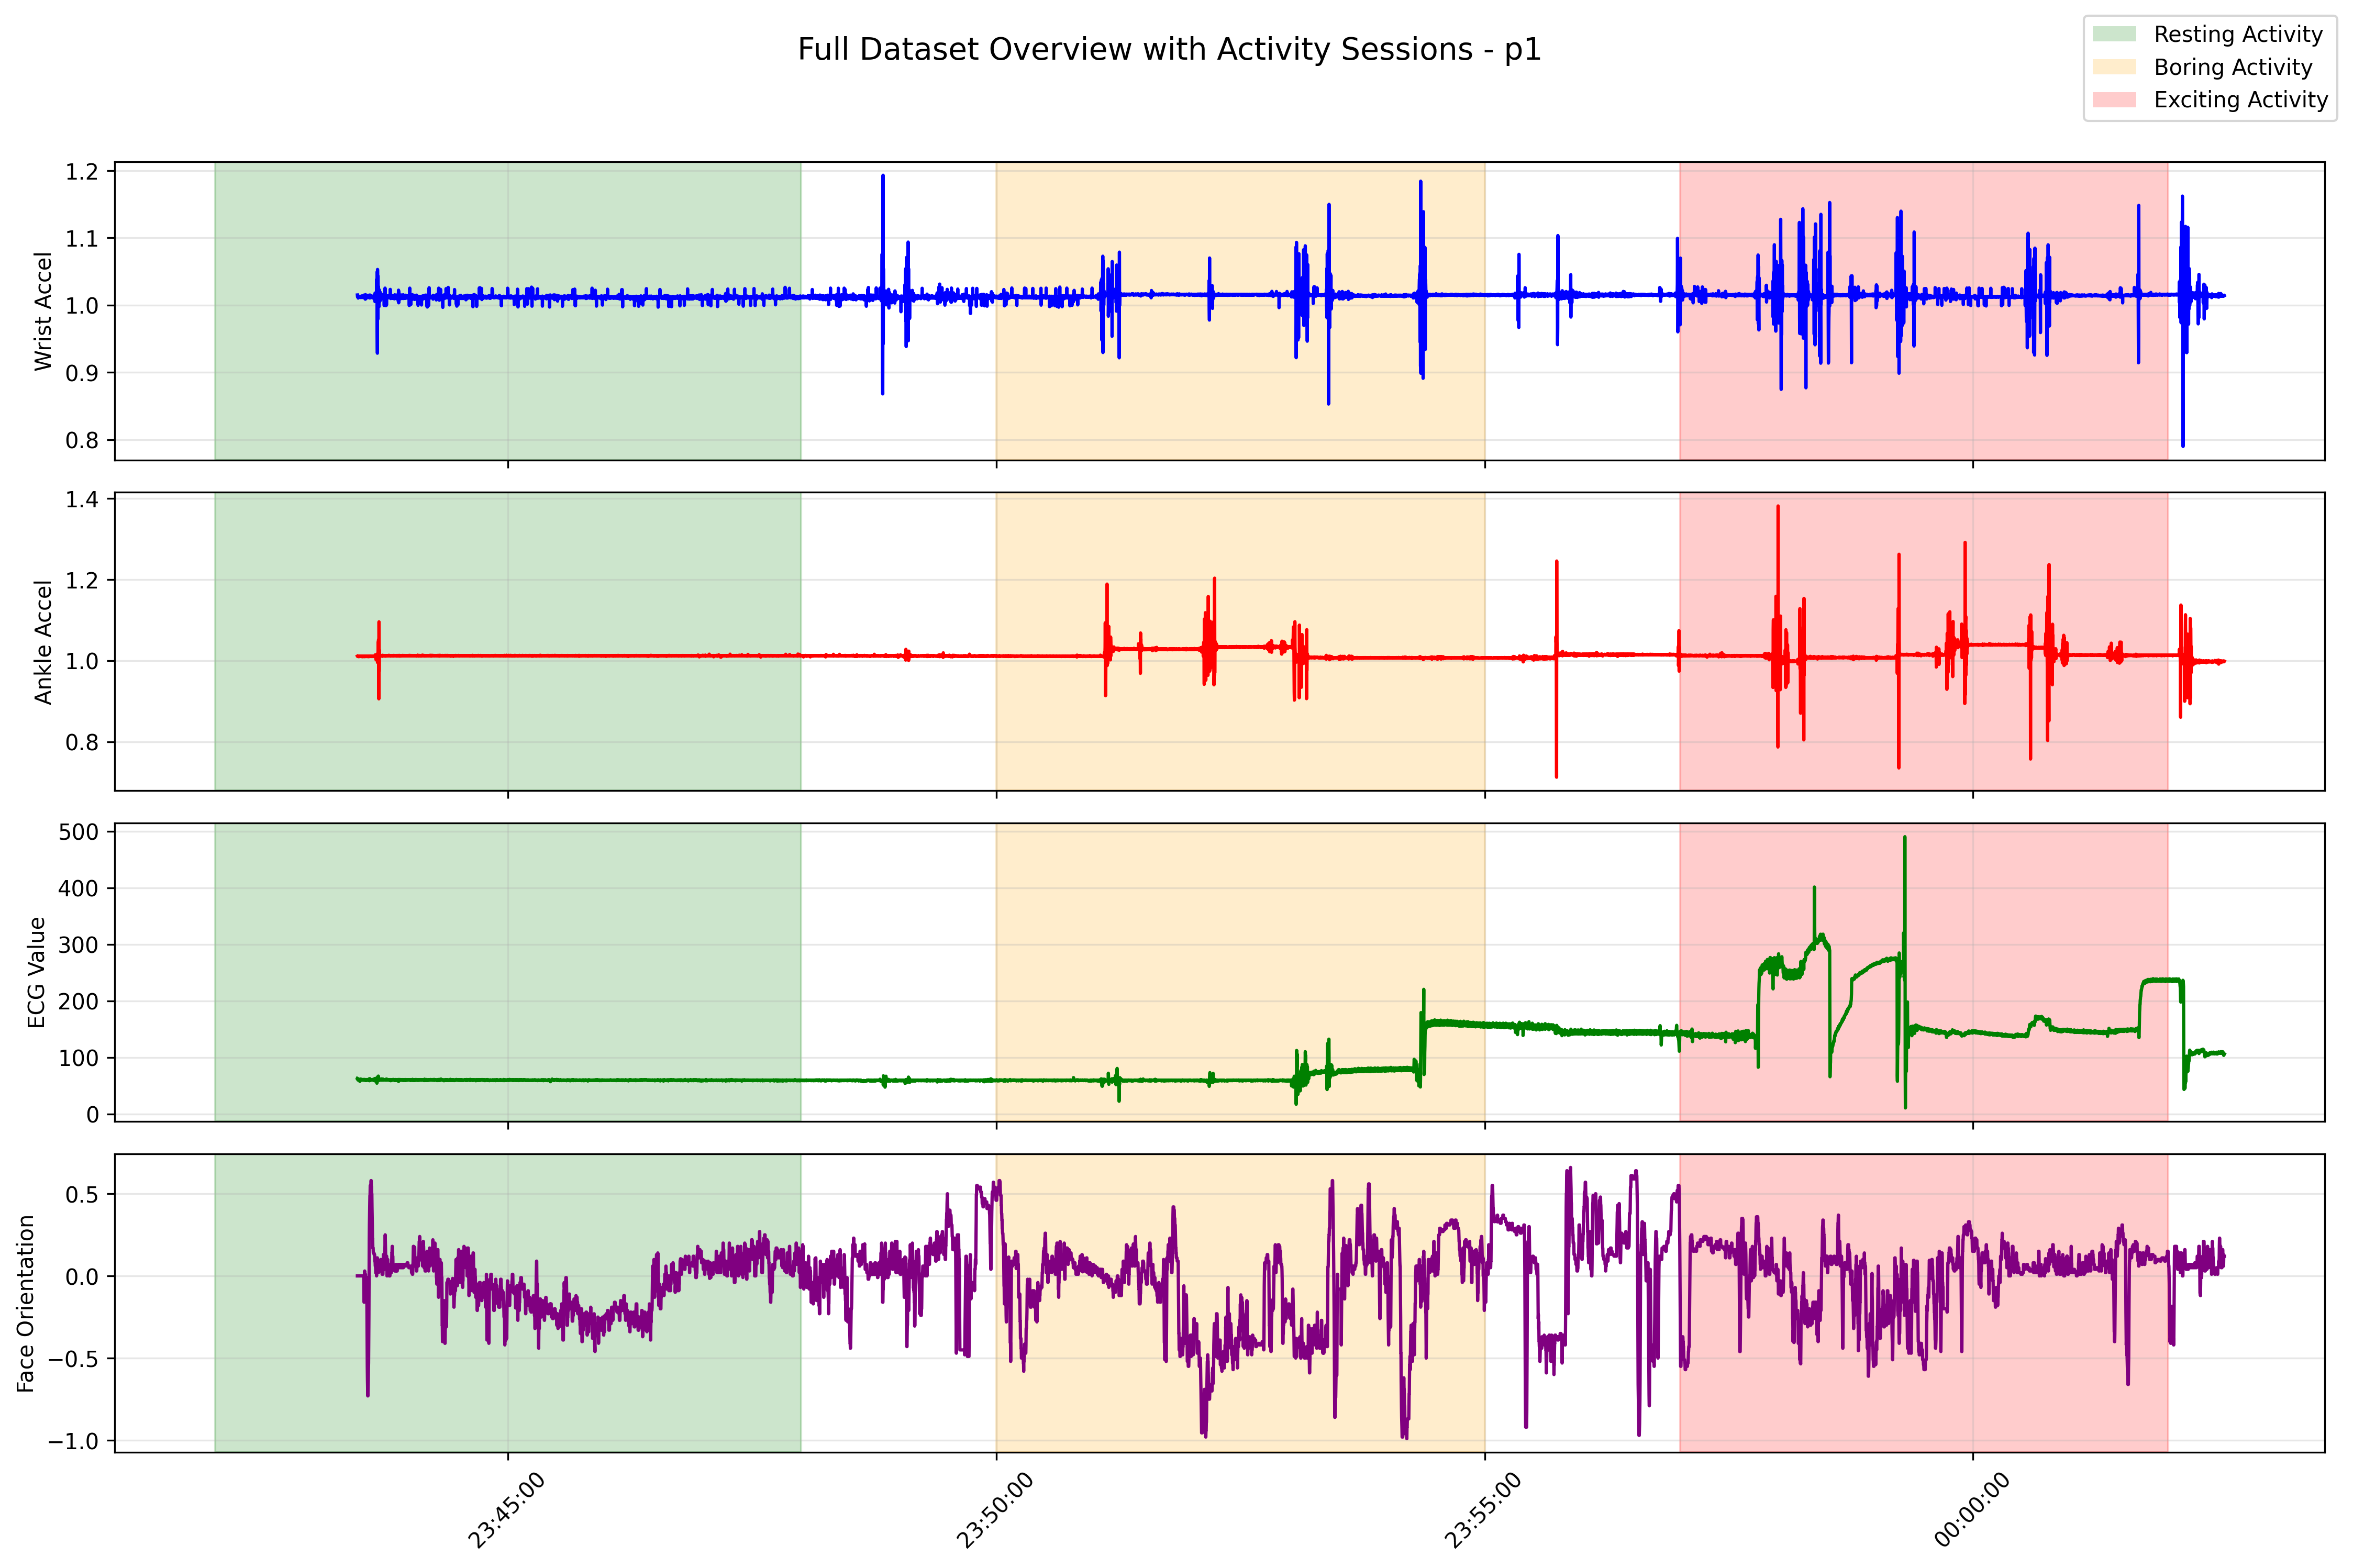

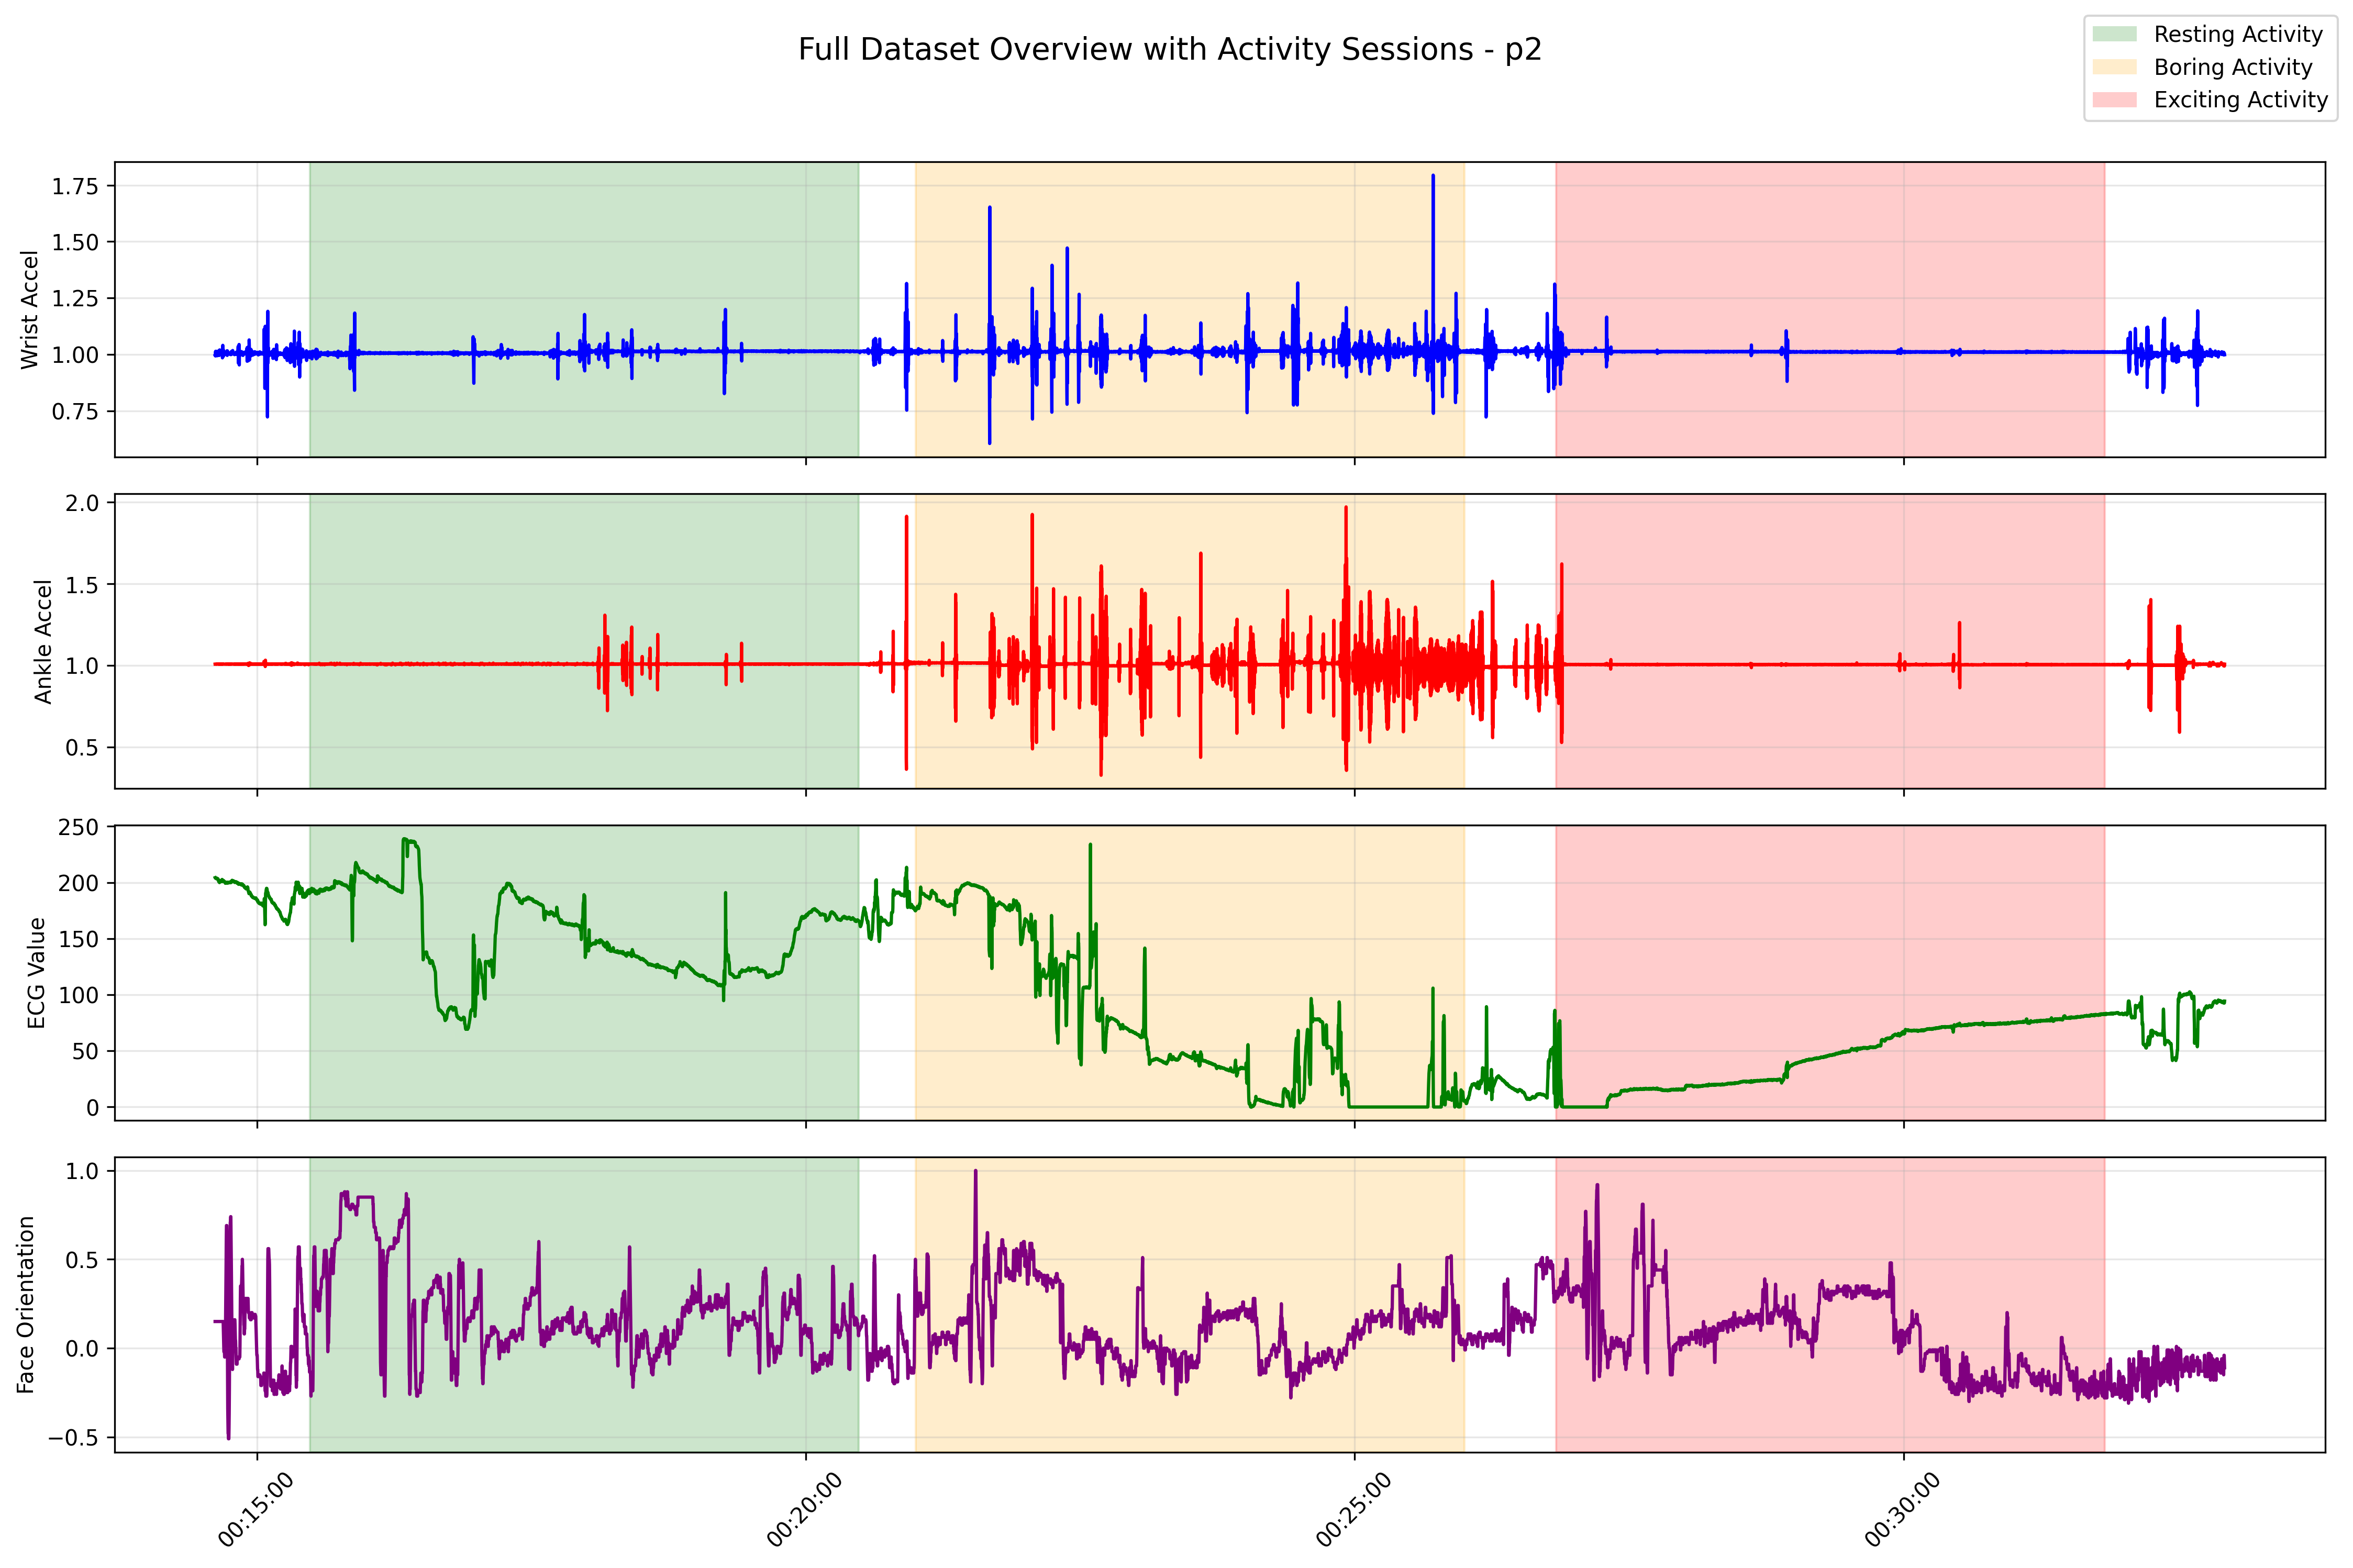

In [17]:
for participant in ['p1', 'p2']:
    overview_path = os.path.join(base_dir, participant, 'figures', 'activity_sessions_overview.png')
    display_image(overview_path)

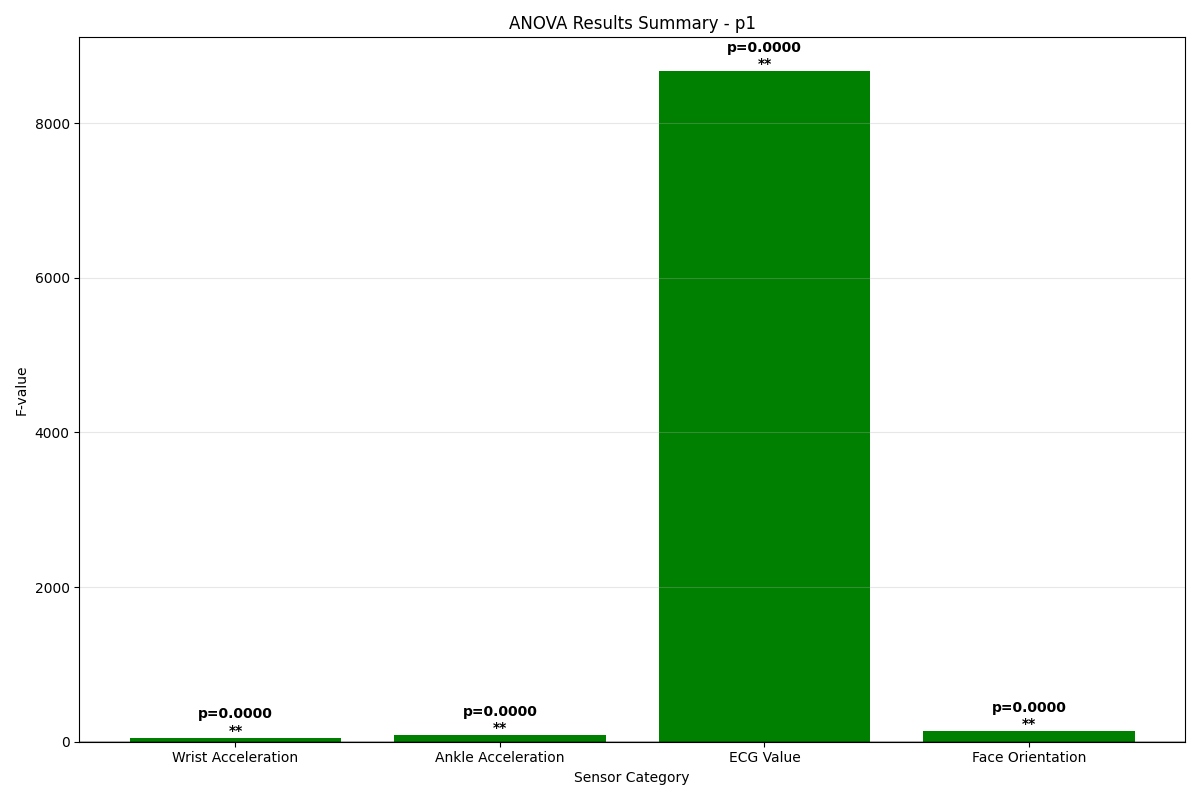

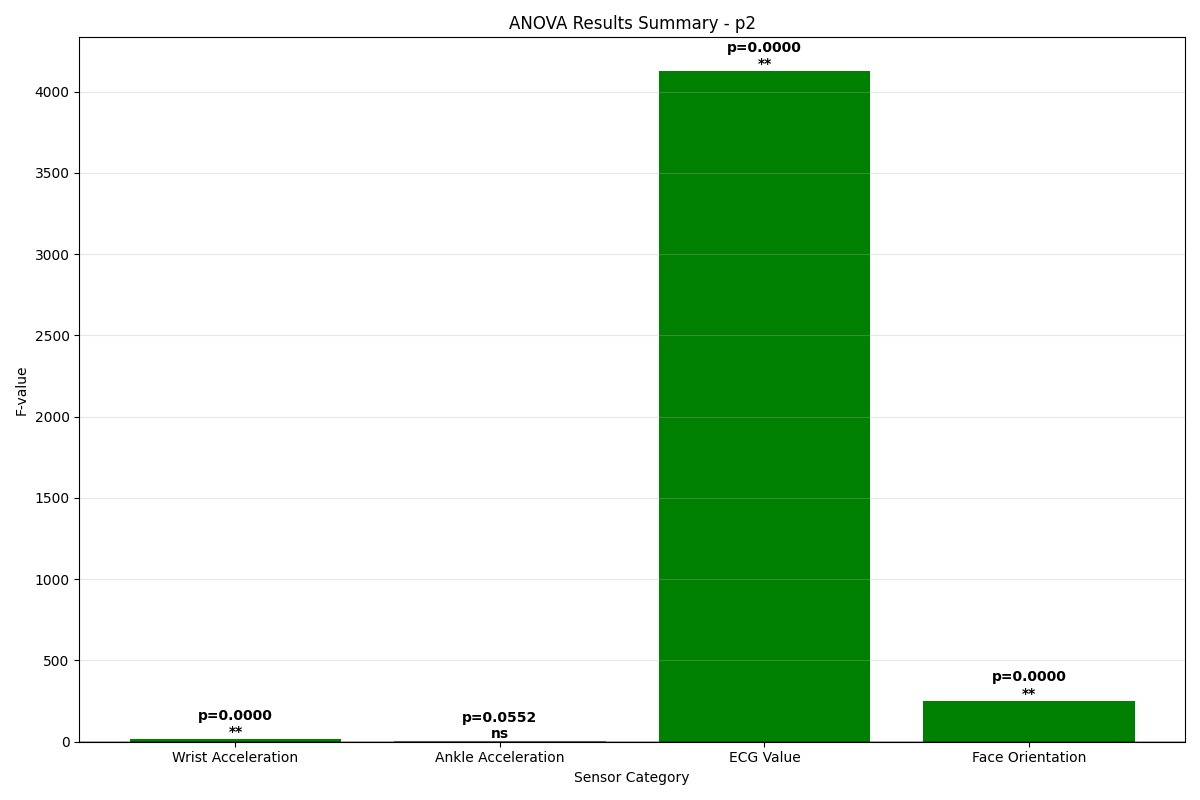

In [18]:
for participant in ['p1', 'p2']:
    anova_summary_path = os.path.join(base_dir, participant, 'figures', 'anova_summary.png')
    display_image(anova_summary_path)


In [19]:
comparison_csv = os.path.join(base_dir, 'p1', 'tests', 'participants_comparison.csv')
if os.path.exists(comparison_csv):
    comparison_df = pd.read_csv(comparison_csv)
    display(comparison_df)

,Sensor,P1 F-value,P1 p-value,P1 Significant,P2 F-value,P2 p-value,P2 Significant
0,Wrist Acceleration,52.518975,2.125619e-23,True,16.652994,6.040125e-08,True
1,Ankle Acceleration,88.677775,7.479764e-39,True,2.898076,5.518062e-02,False
2,ECG Value,8676.696020,0.000000e+00,True,4127.162558,0.000000e+00,True
3,Face Orientation,136.924547,2.808395e-59,True,253.347546,9.083434e-108,True


In [20]:
sensor_categories = [
    {'name': 'wrist_accel', 'title': 'Wrist Acceleration'},
    {'name': 'ankle_accel', 'title': 'Ankle Acceleration'},
    {'name': 'ecg', 'title': 'ECG Value'},
    {'name': 'face', 'title': 'Face Orientation'}
]


In [21]:
# Function to generate sensor-specific sections
def create_sensor_section(sensor_name, sensor_title):
    display(Markdown(f"### {sensor_title}"))

    # Load ANOVA results for both participants
    anova_results = {}
    for participant in ['p1', 'p2']:
        json_path = os.path.join(base_dir, participant, 'tests', 'anova_results.json')
        results = load_json_results(json_path)
        if results and sensor_name in results:
            anova_results[participant] = results[sensor_name]

    # Display boxplots for both participants
    display(Markdown(f"#### Distribution of {sensor_title} Values by Activity Type"))
    for participant in ['p1', 'p2']:
        box_path = os.path.join(base_dir, participant, 'figures', f"{sensor_name}_boxplot.png")
        display(Markdown(f"**Participant {participant.upper()} - Boxplot**"))
        display_image(box_path)

        violin_path = os.path.join(base_dir, participant, 'figures', f"{sensor_name}_violin.png")
        display(Markdown(f"**Participant {participant.upper()} - Violin Plot**"))
        display_image(violin_path)

    # Display Tukey test results if available
    display(Markdown("#### Post-hoc Analysis (Tukey's HSD Test)"))
    for participant in ['p1', 'p2']:
        if participant in anova_results and anova_results[participant].get('significant', False):
            tukey_path = os.path.join(base_dir, participant, 'figures', f"{sensor_name}_tukey.png")
            tukey_text_path = os.path.join(base_dir, participant, 'tests', f"{sensor_name}_tukey_results.txt")

            display(Markdown(f"**Participant {participant.upper()} - Tukey's HSD Test Results**"))

            # Display Tukey plot if available
            if os.path.exists(tukey_path):
                display_image(tukey_path)

            # Display Tukey text results
            tukey_text = load_tukey_results(tukey_text_path)
            if tukey_text:
                display(Markdown("```\n" + tukey_text + "\n```"))

                # Add interpretation of key results
                if 'post_hoc' in anova_results[participant]:
                    post_hoc = anova_results[participant]['post_hoc']
                    sig_comparisons = [p['comparison'] for p in post_hoc if p['significant']]

                    if sig_comparisons:
                        display(Markdown(f"**Significant differences found between:**"))
                        for comp in sig_comparisons:
                            display(Markdown(f"- {comp}"))
                    else:
                        display(Markdown("No significant pairwise differences were found despite overall ANOVA significance."))
        else:
            display(Markdown(f"**Participant {participant.upper()}**: No significant differences found in ANOVA test (p > 0.05), so post-hoc analysis was not performed."))

### Wrist Acceleration

#### Distribution of Wrist Acceleration Values by Activity Type

**Participant P1 - Boxplot**

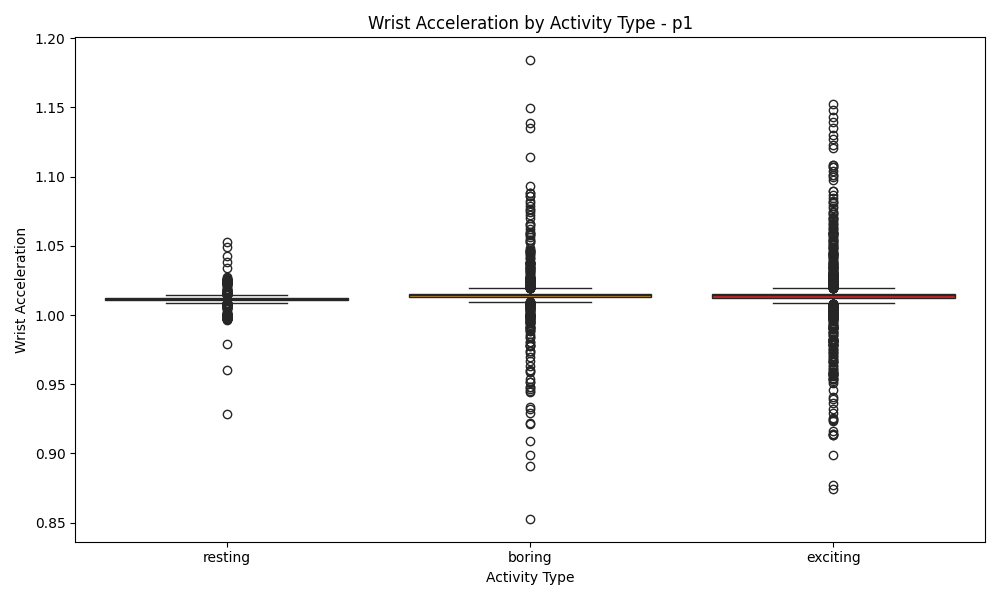

**Participant P1 - Violin Plot**

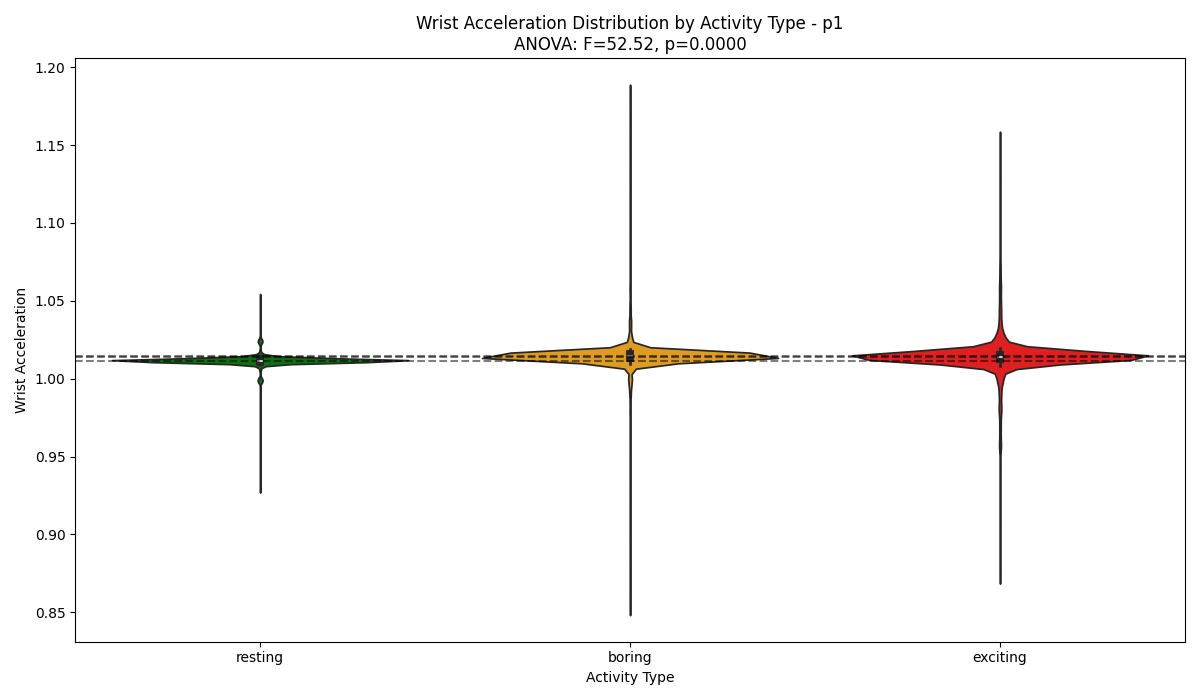

**Participant P2 - Boxplot**

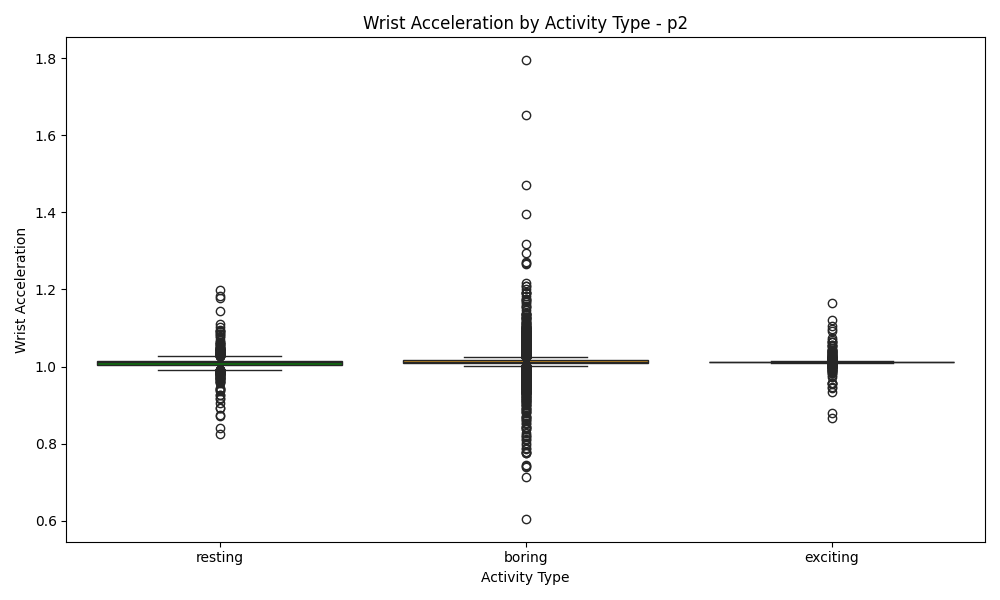

**Participant P2 - Violin Plot**

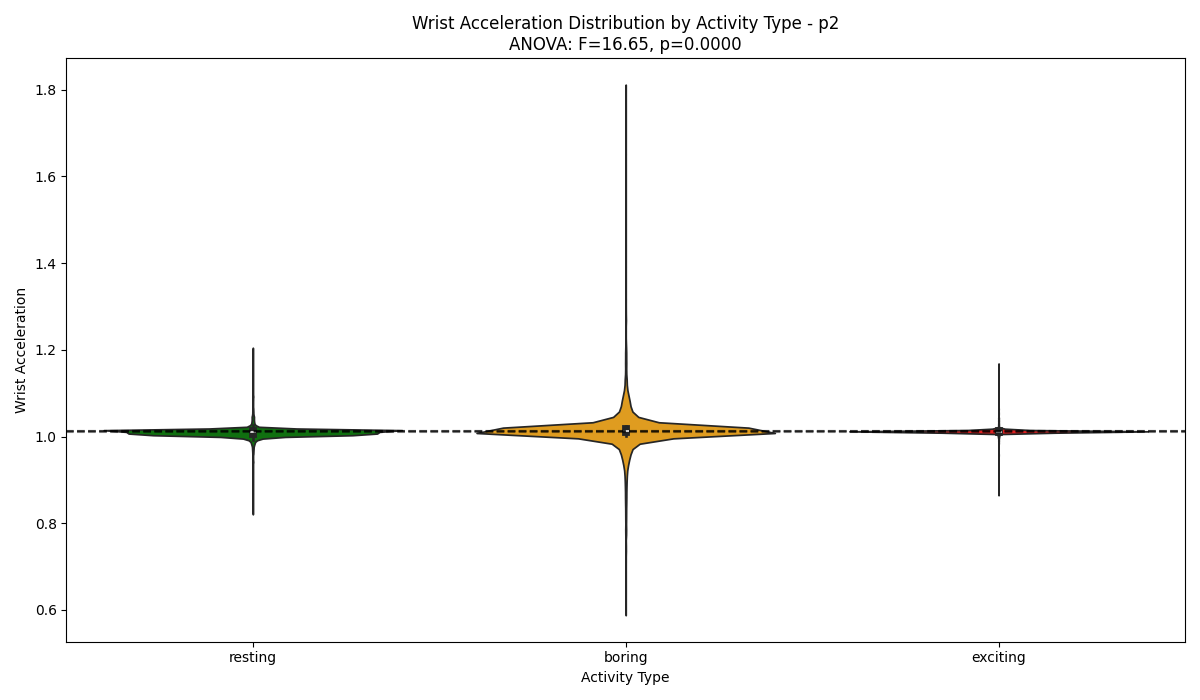

#### Post-hoc Analysis (Tukey's HSD Test)

**Participant P1 - Tukey's HSD Test Results**

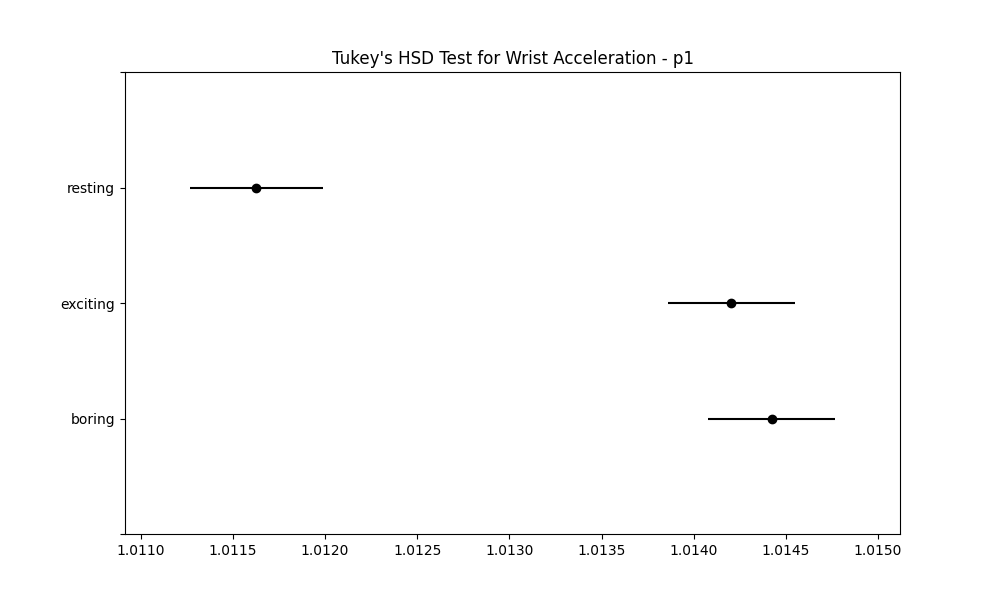

```
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
========================================================
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
  boring exciting  -0.0002 0.7351 -0.0009  0.0005  False
  boring  resting  -0.0028    0.0 -0.0035 -0.0021   True
exciting  resting  -0.0026    0.0 -0.0033 -0.0019   True
--------------------------------------------------------
```

**Significant differences found between:**

- boring vs resting

- exciting vs resting

**Participant P2 - Tukey's HSD Test Results**

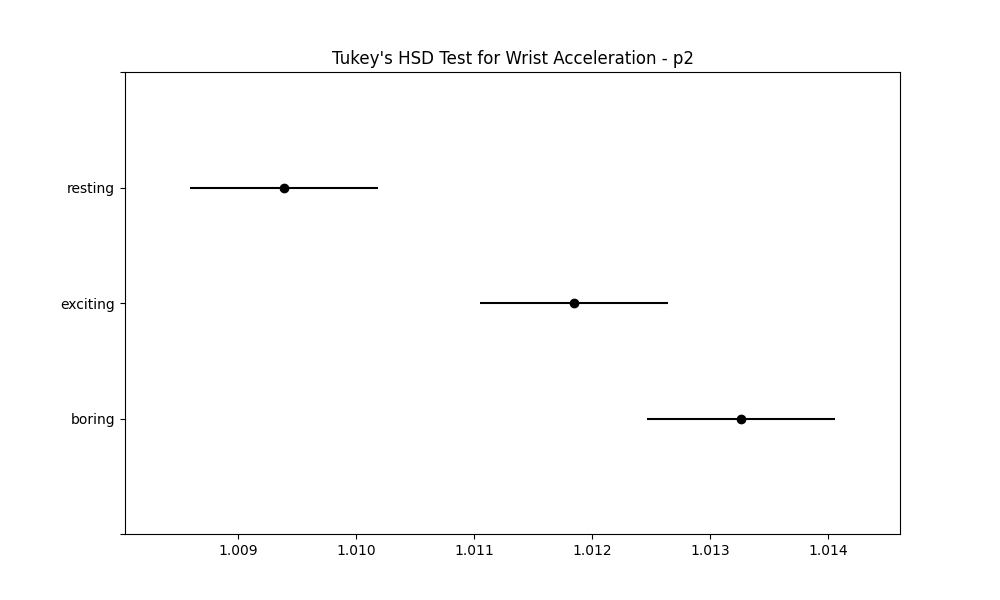

```
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
========================================================
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
  boring exciting  -0.0014 0.0928  -0.003  0.0002  False
  boring  resting  -0.0039    0.0 -0.0055 -0.0023   True
exciting  resting  -0.0025 0.0009 -0.0041 -0.0009   True
--------------------------------------------------------
```

**Significant differences found between:**

- boring vs resting

- exciting vs resting

### Ankle Acceleration

#### Distribution of Ankle Acceleration Values by Activity Type

**Participant P1 - Boxplot**

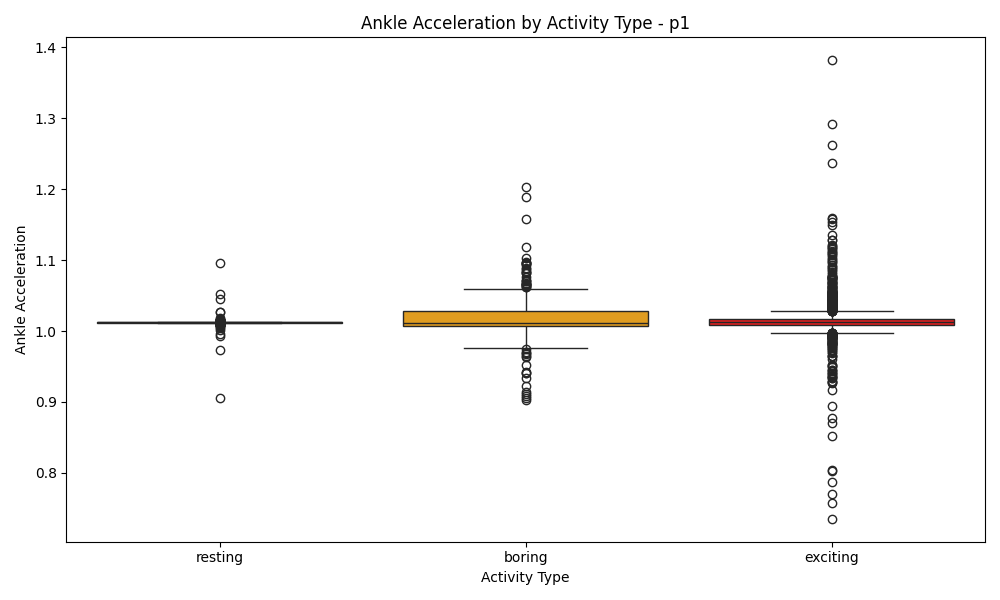

**Participant P1 - Violin Plot**

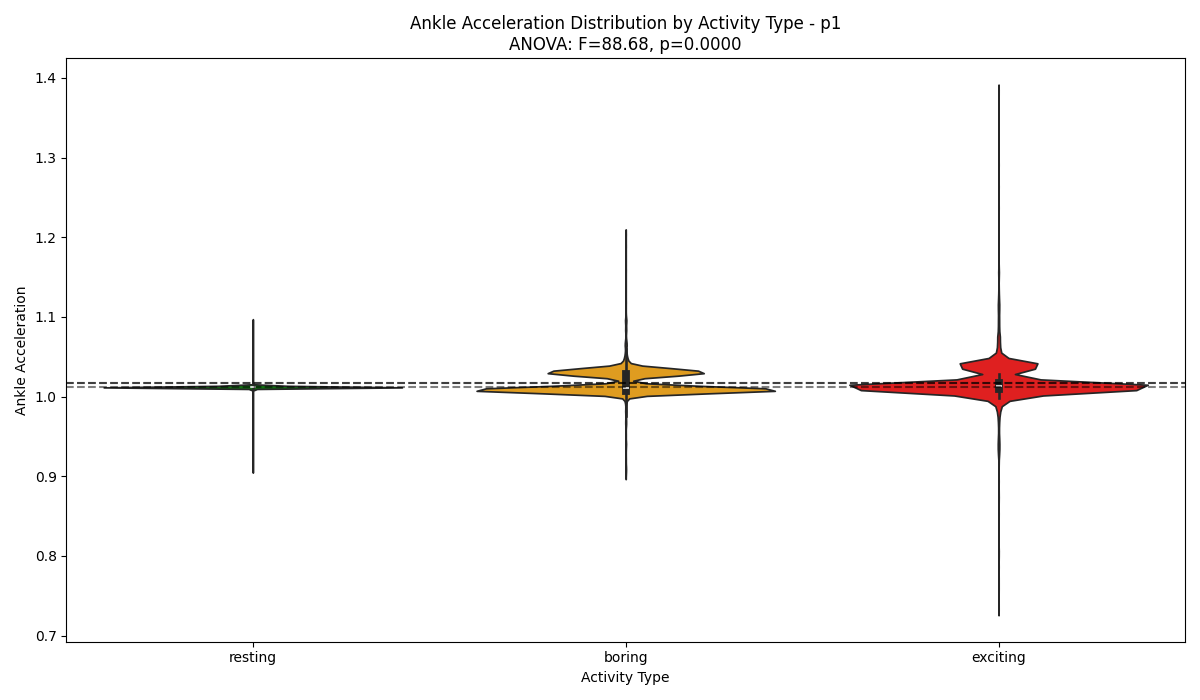

**Participant P2 - Boxplot**

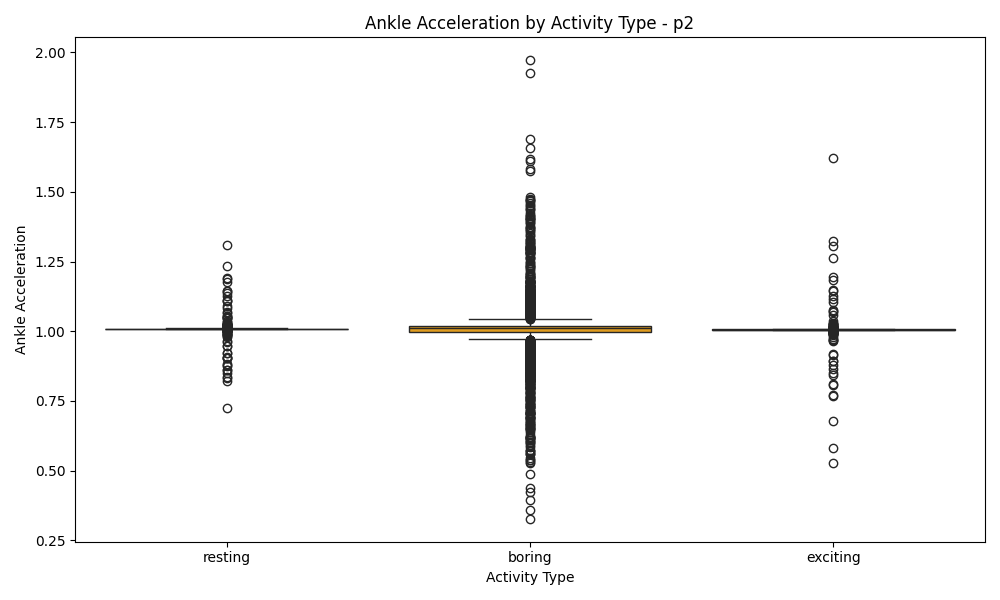

**Participant P2 - Violin Plot**

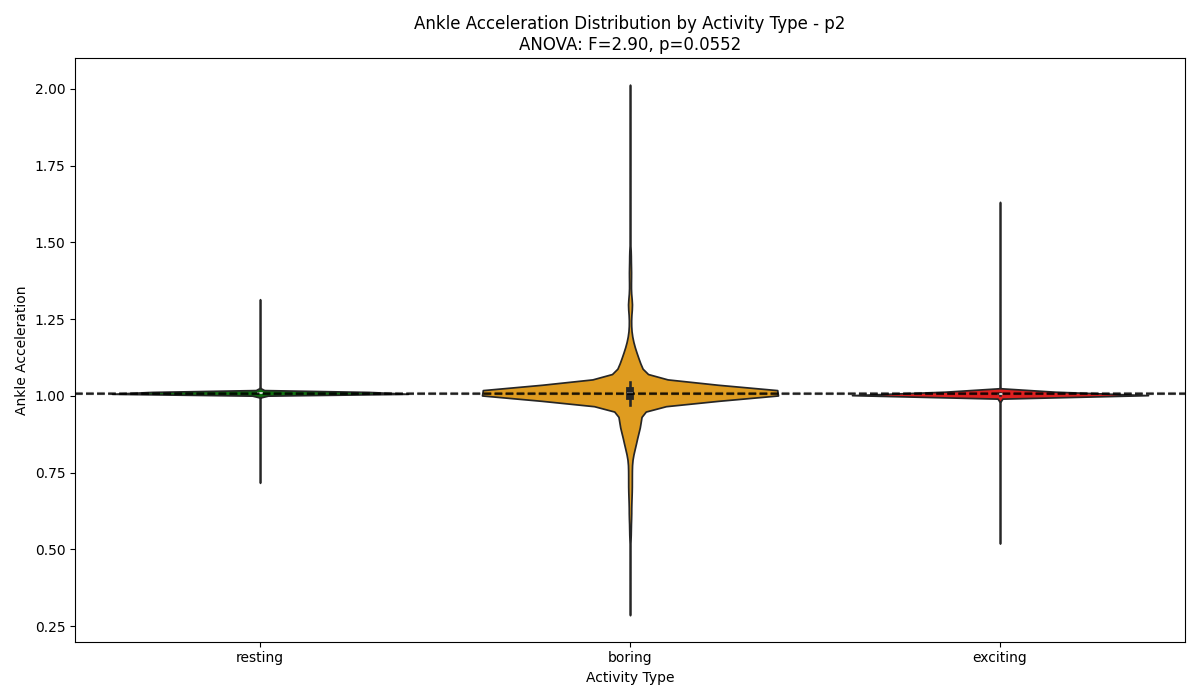

#### Post-hoc Analysis (Tukey's HSD Test)

**Participant P1 - Tukey's HSD Test Results**

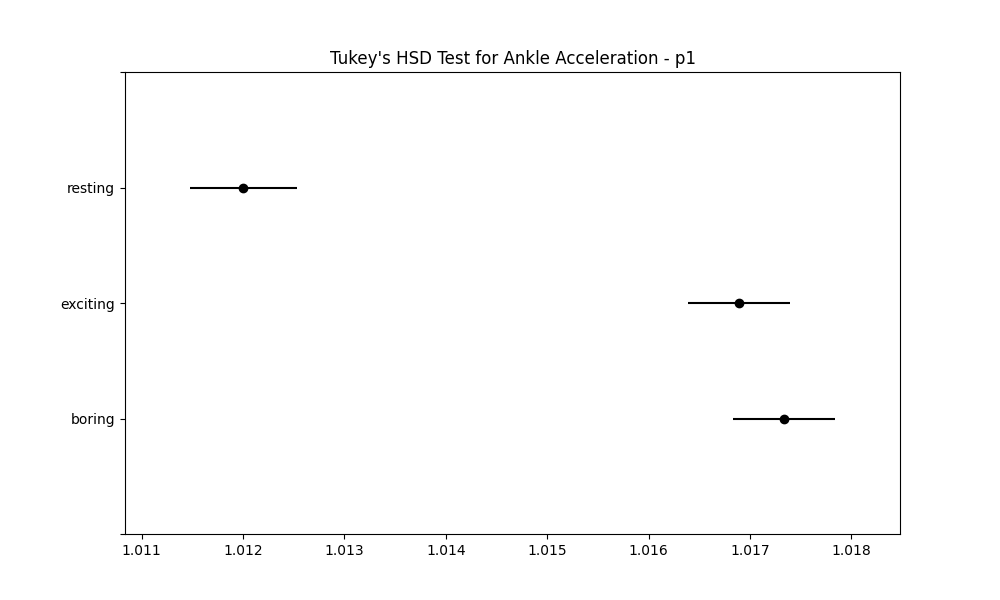

```
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
========================================================
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
  boring exciting  -0.0004 0.5515 -0.0015  0.0006  False
  boring  resting  -0.0053    0.0 -0.0064 -0.0043   True
exciting  resting  -0.0049    0.0 -0.0059 -0.0039   True
--------------------------------------------------------
```

**Significant differences found between:**

- boring vs resting

- exciting vs resting

**Participant P2**: No significant differences found in ANOVA test (p > 0.05), so post-hoc analysis was not performed.

### ECG Value

#### Distribution of ECG Value Values by Activity Type

**Participant P1 - Boxplot**

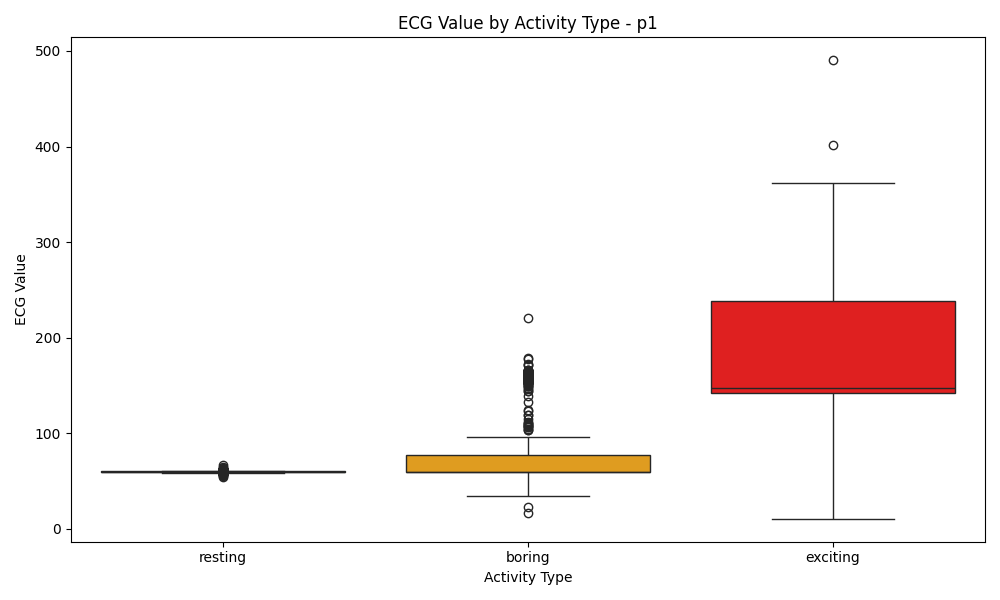

**Participant P1 - Violin Plot**

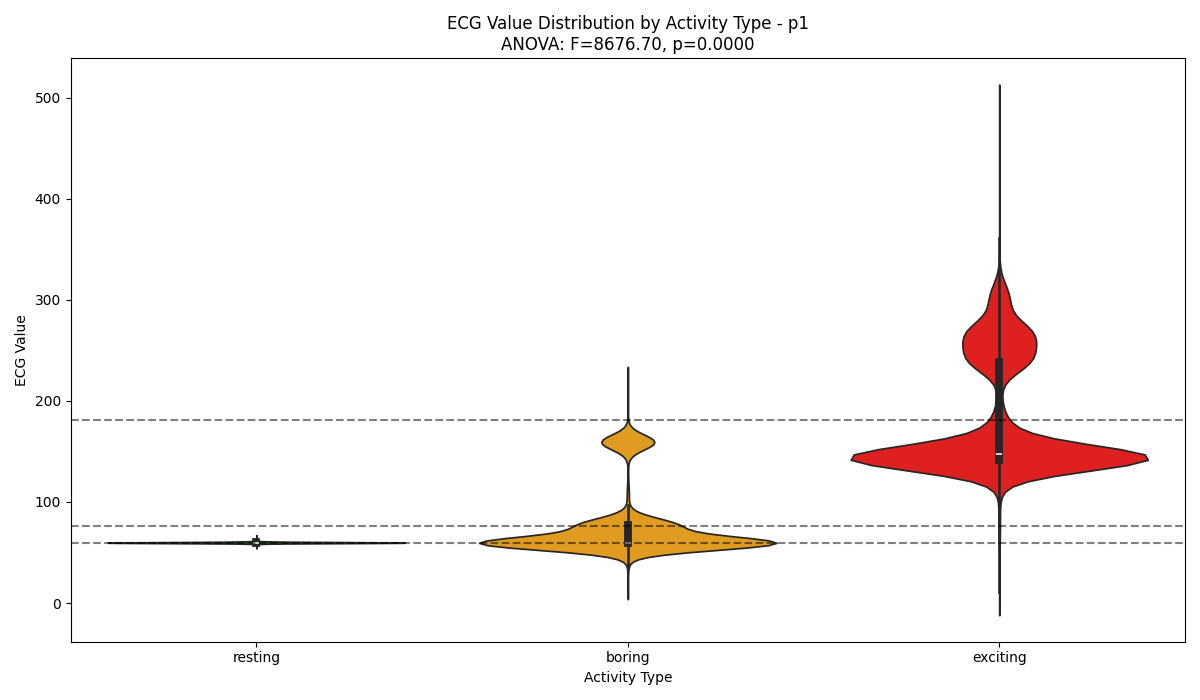

**Participant P2 - Boxplot**

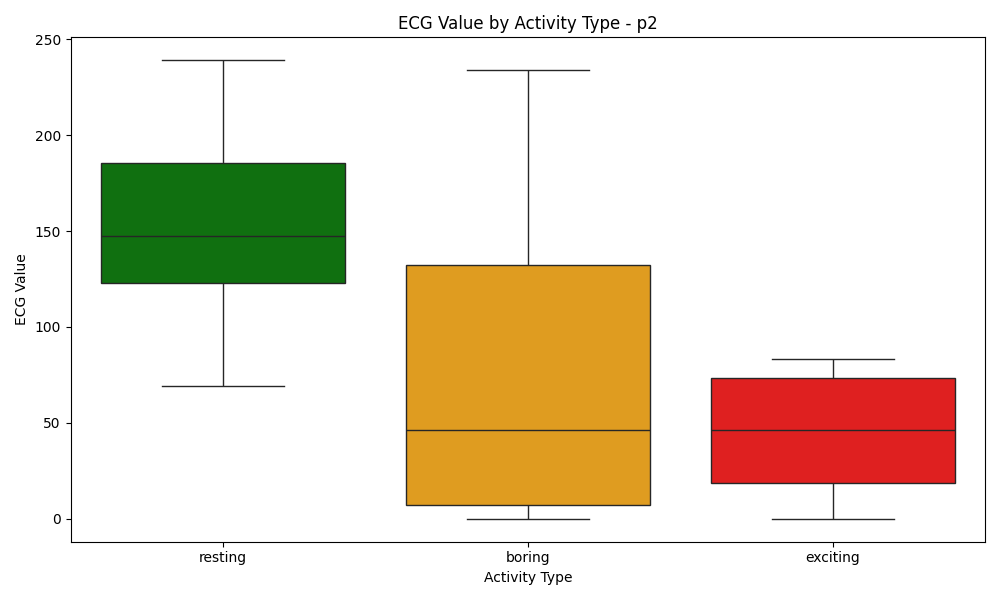

**Participant P2 - Violin Plot**

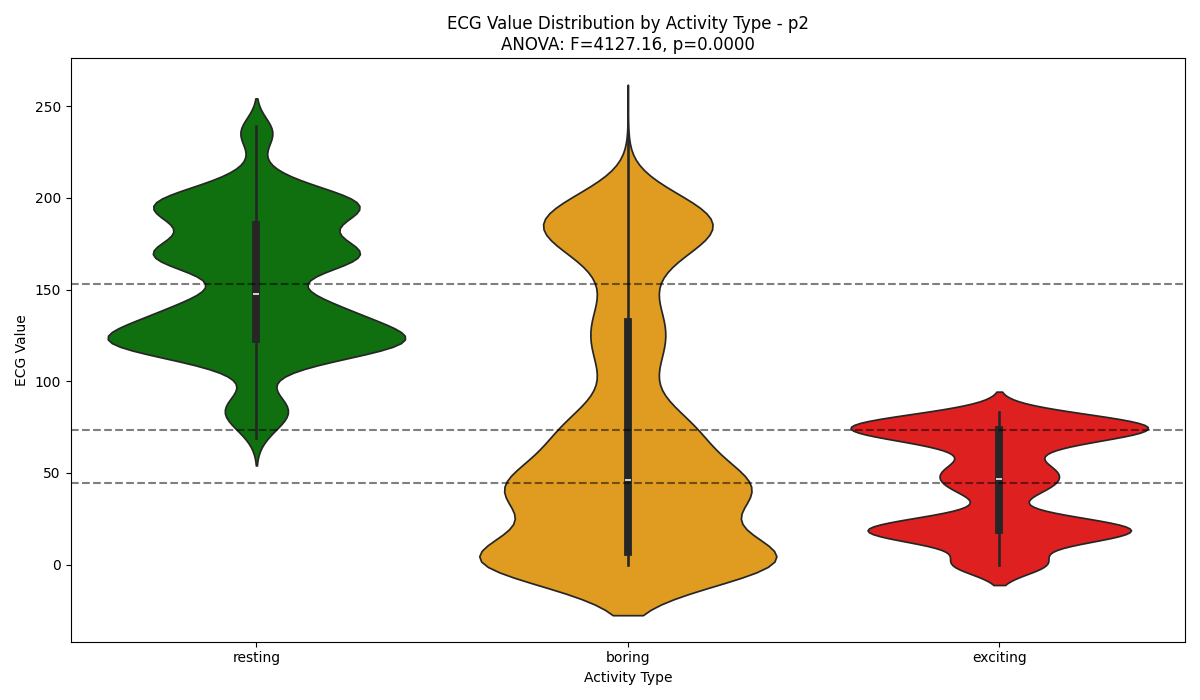

#### Post-hoc Analysis (Tukey's HSD Test)

**Participant P1 - Tukey's HSD Test Results**

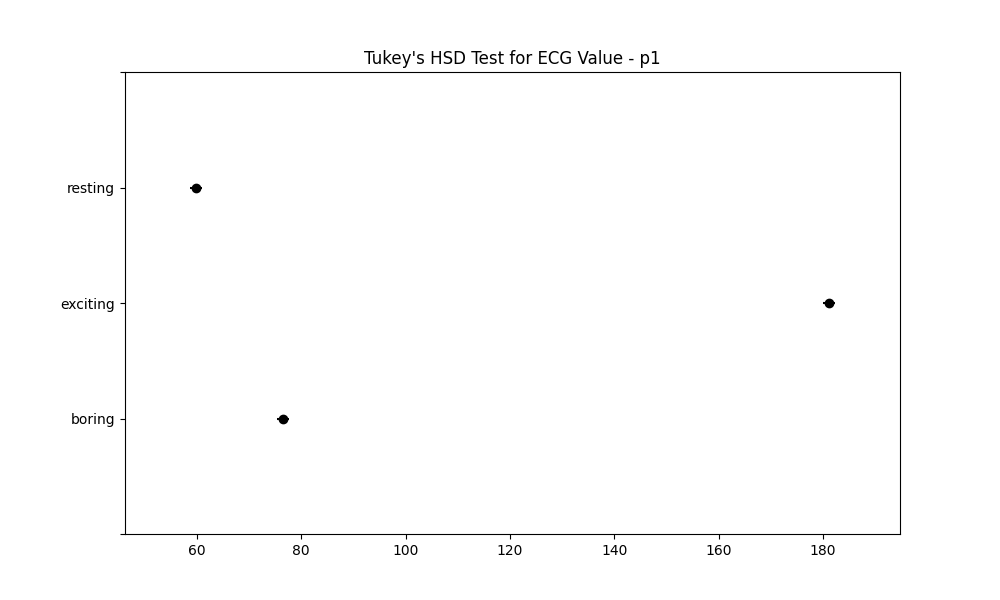

```
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
============================================================
 group1   group2   meandiff p-adj   lower     upper   reject
------------------------------------------------------------
  boring exciting  104.7755   0.0  102.4598  107.0912   True
  boring  resting  -16.6592   0.0  -19.0323   -14.286   True
exciting  resting -121.4347   0.0 -123.8078 -119.0615   True
------------------------------------------------------------
```

**Significant differences found between:**

- boring vs exciting

- boring vs resting

- exciting vs resting

**Participant P2 - Tukey's HSD Test Results**

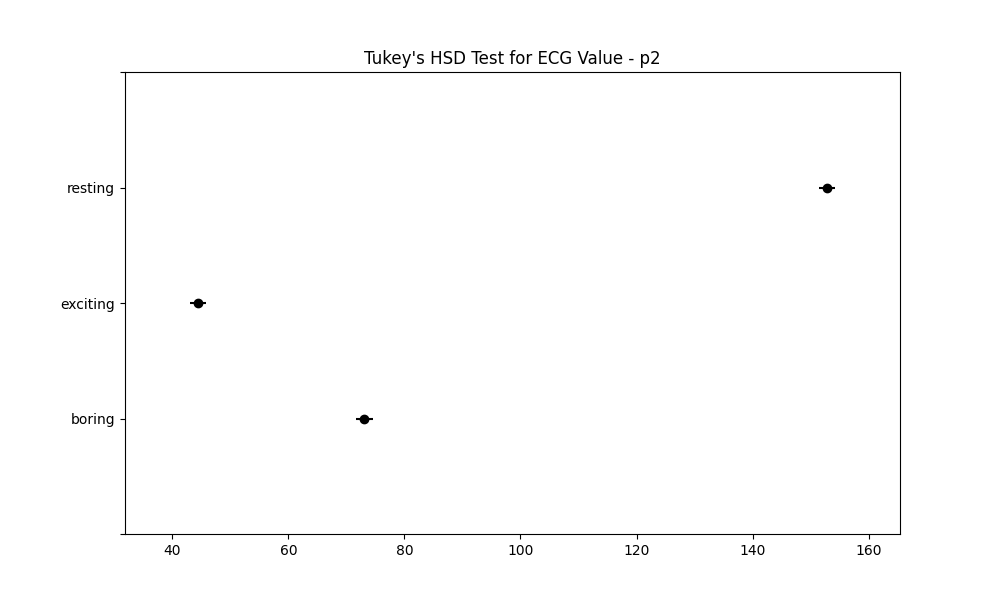

```
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
=========================================================
 group1   group2  meandiff p-adj  lower    upper   reject
---------------------------------------------------------
  boring exciting  -28.687   0.0 -31.5852 -25.7888   True
  boring  resting  79.7116   0.0  76.8134  82.6098   True
exciting  resting 108.3987   0.0 105.5004 111.2969   True
---------------------------------------------------------
```

**Significant differences found between:**

- boring vs exciting

- boring vs resting

- exciting vs resting

### Face Orientation

#### Distribution of Face Orientation Values by Activity Type

**Participant P1 - Boxplot**

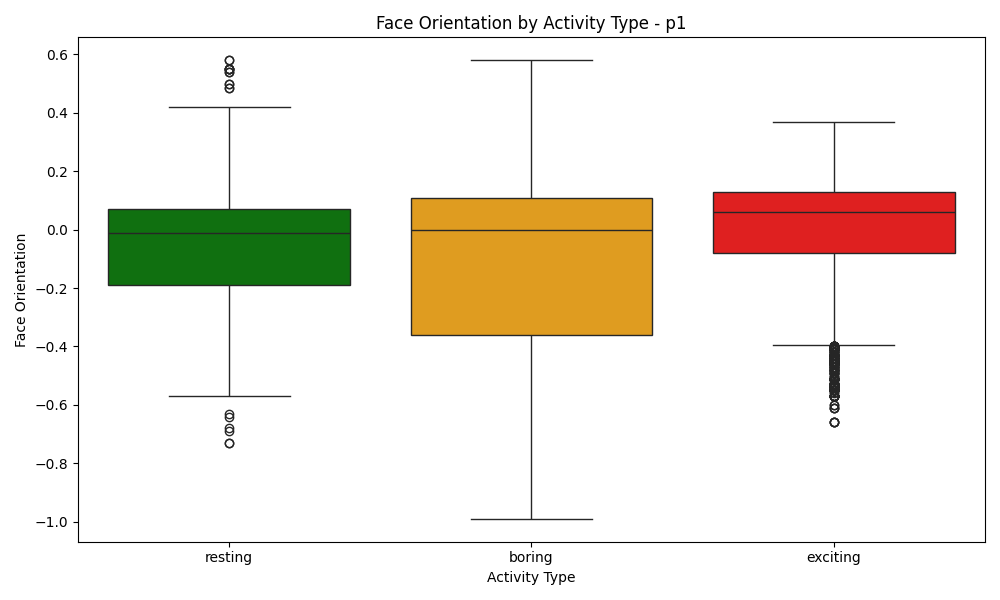

**Participant P1 - Violin Plot**

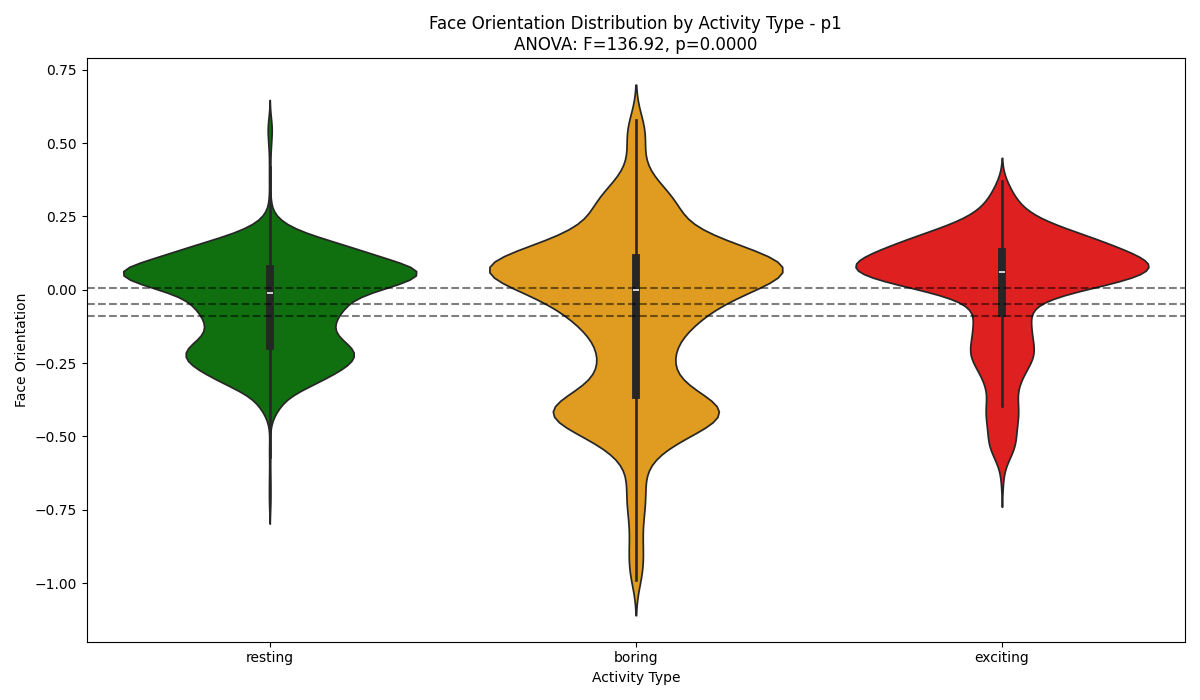

**Participant P2 - Boxplot**

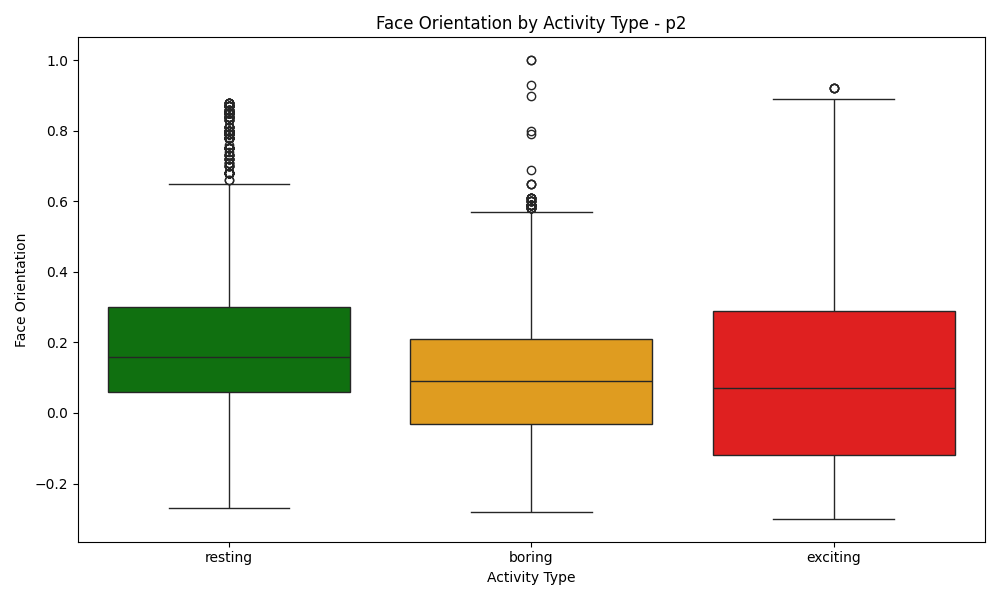

**Participant P2 - Violin Plot**

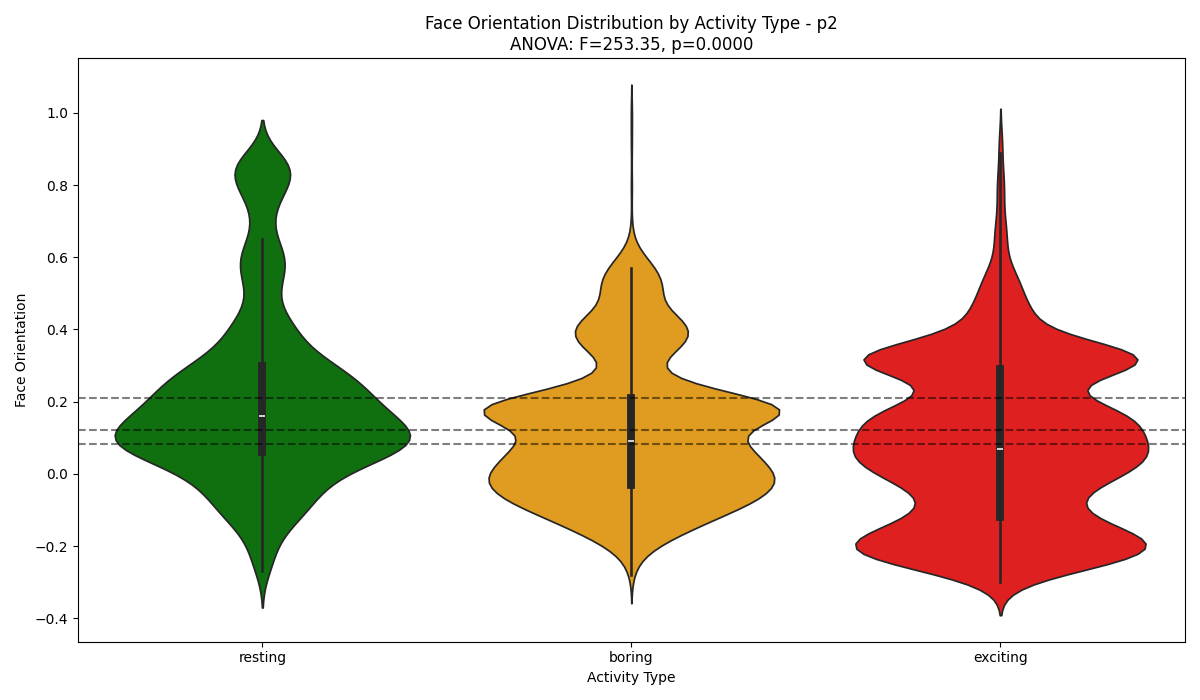

#### Post-hoc Analysis (Tukey's HSD Test)

**Participant P1 - Tukey's HSD Test Results**

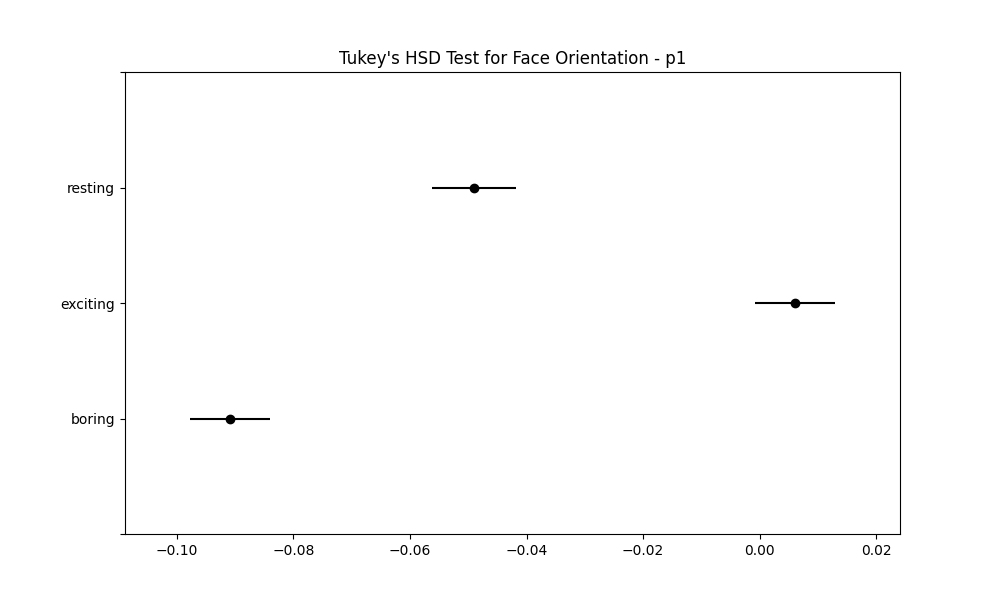

```
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
======================================================
 group1   group2  meandiff p-adj  lower  upper  reject
------------------------------------------------------
  boring exciting    0.097   0.0  0.0833 0.1108   True
  boring  resting   0.0419   0.0  0.0278  0.056   True
exciting  resting  -0.0551   0.0 -0.0693 -0.041   True
------------------------------------------------------
```

**Significant differences found between:**

- boring vs exciting

- boring vs resting

- exciting vs resting

**Participant P2 - Tukey's HSD Test Results**

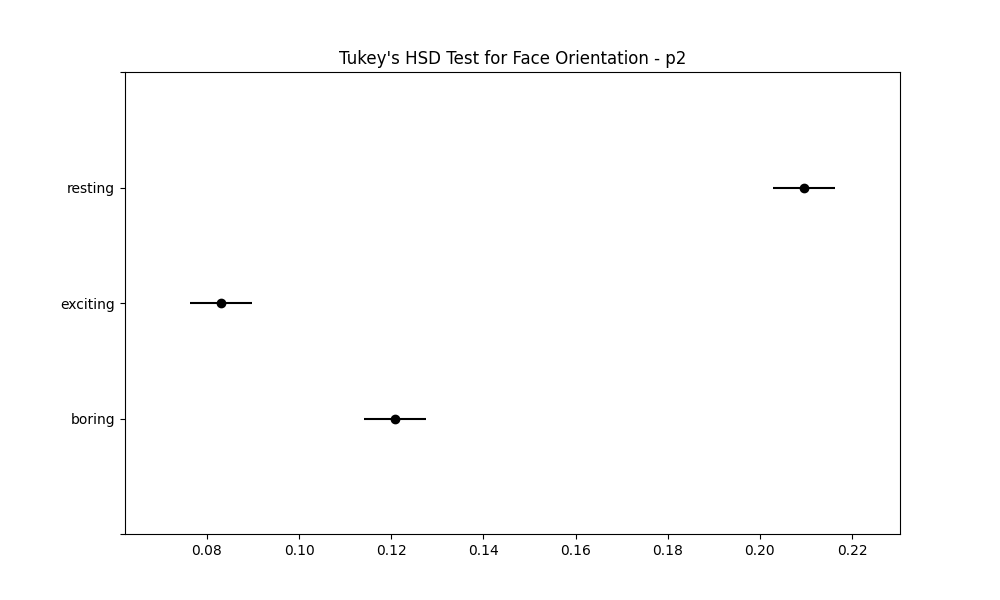

```
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
=======================================================
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
  boring exciting  -0.0378   0.0 -0.0513 -0.0242   True
  boring  resting   0.0889   0.0  0.0753  0.1024   True
exciting  resting   0.1266   0.0  0.1131  0.1402   True
-------------------------------------------------------
```

**Significant differences found between:**

- boring vs exciting

- boring vs resting

- exciting vs resting

In [22]:
for sensor in sensor_categories:
    create_sensor_section(sensor['name'], sensor['title'])